In [77]:
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import shap

import json

import time
from sklearn.preprocessing import RobustScaler

from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from lightgbm import LGBMRegressor
from scipy.stats import boxcox
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import plotly.graph_objects as go
import plotly.io as pio

import seaborn as sns

import shap
from scipy.stats import boxcox
from utils import inverse_boxcox
from utils import BikeDemandDataProcessor

from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import clear_output
plt.style.use('ggplot')
%matplotlib inline

pio.renderers.default = 'vscode'
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Data Loading

## Dataset Characteristics

- **instant**: record index
- **dteday**: date
- **season**: season (1: spring, 2: summer, 3: fall, 4: winter)
- **yr**: year (0: 2011, 1: 2012)
- **mnth**: month (1 to 12)
- **hr**: hour (0 to 23)
- **holiday**: whether the day is a holiday or not
- **day_of_week**: day of the week
- **workingday**: if the day is neither weekend nor holiday is 1, otherwise is 0
- **weathersit**:
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp**: Normalized temperature in Celsius. The values are divided by 41 (max)
- **atemp**: Normalized feeling temperature in Celsius. The values are divided by 50 (max)
- **hum**: Normalized humidity. The values are divided by 100 (max)
- **windspeed**: Normalized wind speed. The values are divided by 67 (max)
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registered

In [78]:
parent_path = Path().resolve()
processor = BikeDemandDataProcessor(parent_path)
hour_raw_df = processor.load_data("data/hour.csv")
hour_processed_df = processor.preprocess(hour_raw_df)

Loading data from C:\Users\Lawrence\Documents\PYTHON\bike_demand_2025/data/hour.csv


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\utils.py:97: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\utils.py:98: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [79]:
test_period = 28*24

test_df = hour_processed_df[-test_period:]
test_df.to_csv("data/processed_data/test.csv", index=False)
train_df, val_df = processor.split_and_engineer_data(hour_processed_df[:-test_period])

**Orginal Data**

In [80]:
hour_raw_df.head(5)

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  01/01/2011       1   0     1   0        0        6           0   
1        2  01/01/2011       1   0     1   1        0        6           0   
2        3  01/01/2011       1   0     1   2        0        6           0   
3        4  01/01/2011       1   0     1   3        0        6           0   
4        5  01/01/2011       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [108]:
hour_raw_df.shape

(17379, 17)

In [115]:
for feature in [feature for feature in hour_raw_df.columns if len(hour_raw_df[feature].unique()) < 50]:
    print(f'{feature}: {hour_raw_df[feature].unique()}')

season: [1 2 3 4]
yr: [0 1]
mnth: [ 1  2  3  4  5  6  7  8  9 10 11 12]
hr: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
holiday: [0 1]
weekday: [6 0 1 2 3 4 5]
workingday: [0 1]
weathersit: [1 2 3 4]
windspeed: [0.     0.0896 0.2537 0.2836 0.2985 0.194  0.2239 0.1343 0.1642 0.3284
 0.4478 0.3582 0.4179 0.3881 0.1045 0.4925 0.5522 0.4627 0.5224 0.5821
 0.6567 0.6119 0.7761 0.6866 0.7463 0.6418 0.806  0.8507 0.8358 0.7164]


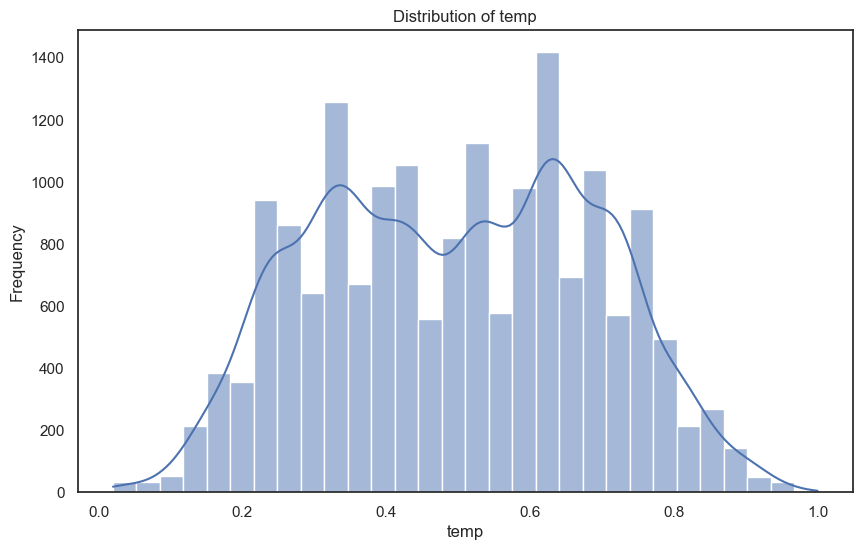

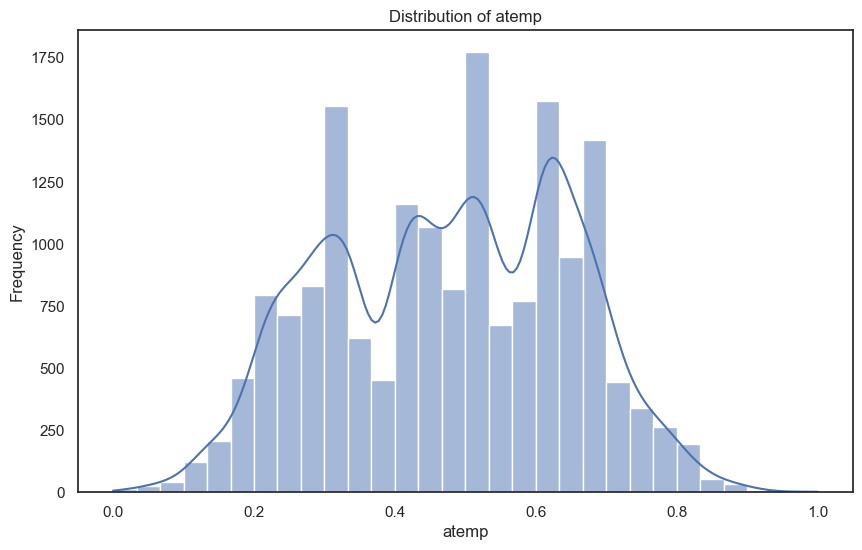

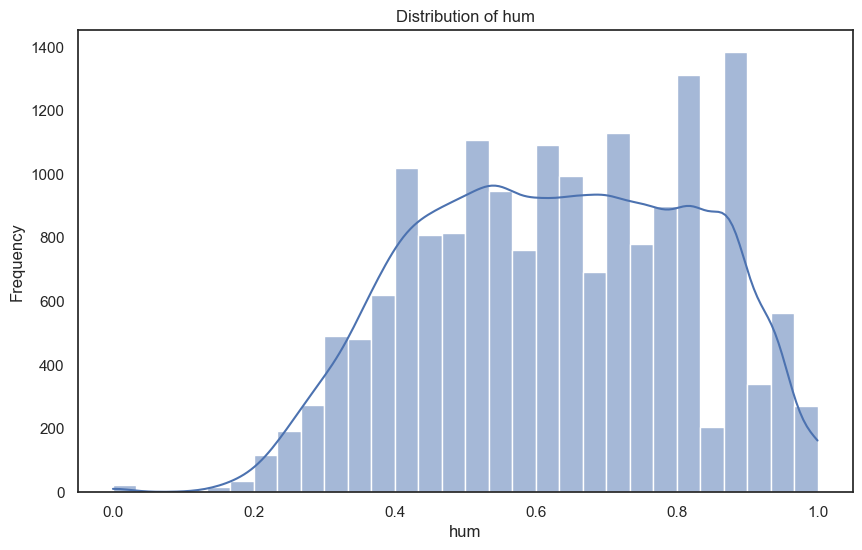

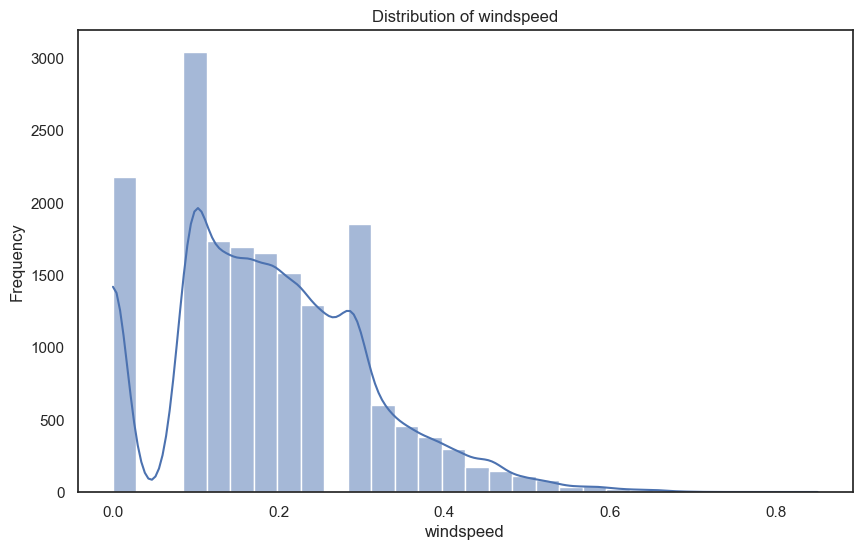

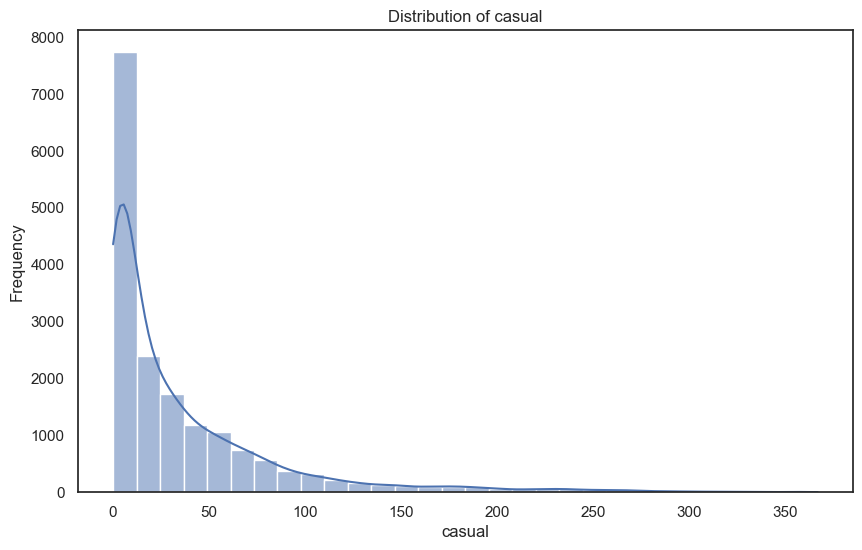

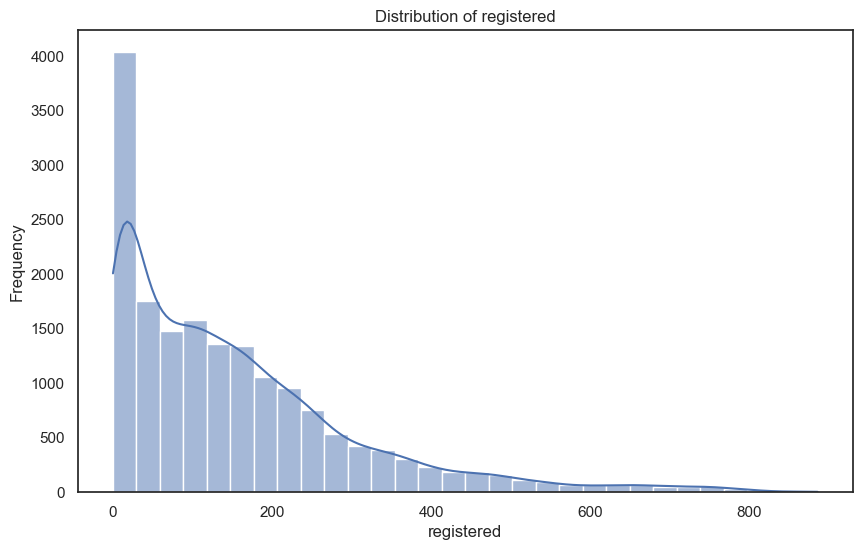

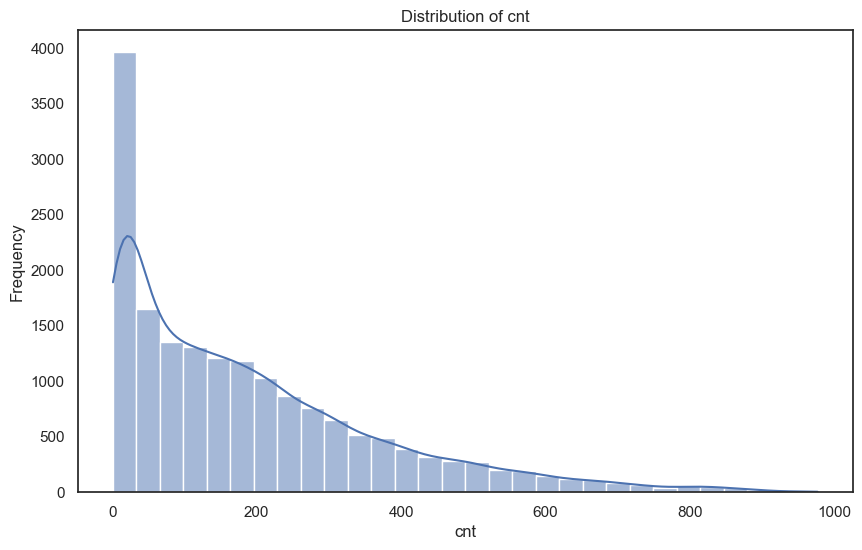

In [119]:
for feature in [feature for feature in hour_raw_df.columns if len(hour_raw_df[feature].unique()) > 24 and feature not in ['dteday', 'instant']]:
    plt.figure(figsize=(10, 6))
    sns.histplot(hour_raw_df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [81]:
hour_raw_df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

**Data with Time Features and Other Feature Engineering**

In [82]:
hour_processed_df.head(5)

season  year  month  hour  holiday  weekday  workingday  weathersit  temp  \
0       1  2011      1     0        0        6           0           1  0.24   
1       1  2011      1     1        0        6           0           1  0.22   
2       1  2011      1     2        0        6           0           1  0.22   
3       1  2011      1     3        0        6           0           1  0.24   
4       1  2011      1     4        0        6           0           1  0.24   

    atemp  ...  weather_hum  weather_windspeed  atemp_hum  atemp_windspeed  \
0  0.2879  ...         0.81                0.0   0.233199              0.0   
1  0.2727  ...         0.80                0.0   0.218160              0.0   
2  0.2727  ...         0.80                0.0   0.218160              0.0   
3  0.2879  ...         0.75                0.0   0.215925              0.0   
4  0.2879  ...         0.75                0.0   0.215925              0.0   

   atemp_squared temp_atemp  weather_atemp  temp_atemp_diff  count_lag_28d  \
0       0.082886   0.069096         0.2879           0.0479           16.0   
1       0.074365   0.059994         0.2727           0.0527           16.0   
2       0.074365   0.059994         0.2727           0.0527           16.0   
3       0.082886   0.069096         0.2879           0.0479           16.0   
4       0.082886   0.069096         0.2879           0.0479           16.0   

   count_lag_1y  
0          16.0  
1          16.0  
2          16.0  
3          16.0  
4          16.0  

[5 rows x 61 columns]

In [83]:
hour_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 61 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   season                    17379 non-null  int64         
 1   year                      17379 non-null  int32         
 2   month                     17379 non-null  int32         
 3   hour                      17379 non-null  int64         
 4   holiday                   17379 non-null  int64         
 5   weekday                   17379 non-null  int64         
 6   workingday                17379 non-null  int64         
 7   weathersit                17379 non-null  int64         
 8   temp                      17379 non-null  float64       
 9   atemp                     17379 non-null  float64       
 10  hum                       17379 non-null  float64       
 11  windspeed                 17379 non-null  float64       
 12  casual            

In [84]:
hour_processed_df.head()

season  year  month  hour  holiday  weekday  workingday  weathersit  temp  \
0       1  2011      1     0        0        6           0           1  0.24   
1       1  2011      1     1        0        6           0           1  0.22   
2       1  2011      1     2        0        6           0           1  0.22   
3       1  2011      1     3        0        6           0           1  0.24   
4       1  2011      1     4        0        6           0           1  0.24   

    atemp  ...  weather_hum  weather_windspeed  atemp_hum  atemp_windspeed  \
0  0.2879  ...         0.81                0.0   0.233199              0.0   
1  0.2727  ...         0.80                0.0   0.218160              0.0   
2  0.2727  ...         0.80                0.0   0.218160              0.0   
3  0.2879  ...         0.75                0.0   0.215925              0.0   
4  0.2879  ...         0.75                0.0   0.215925              0.0   

   atemp_squared temp_atemp  weather_atemp  temp_atemp_diff  count_lag_28d  \
0       0.082886   0.069096         0.2879           0.0479           16.0   
1       0.074365   0.059994         0.2727           0.0527           16.0   
2       0.074365   0.059994         0.2727           0.0527           16.0   
3       0.082886   0.069096         0.2879           0.0479           16.0   
4       0.082886   0.069096         0.2879           0.0479           16.0   

   count_lag_1y  
0          16.0  
1          16.0  
2          16.0  
3          16.0  
4          16.0  

[5 rows x 61 columns]

**No Nulls in Data**

In [85]:
null_counts = hour_processed_df.isnull().sum()
print(null_counts[null_counts > 0])

Series([], dtype: int64)


**Some checks to see the alignment of days**

In [86]:
hour_processed_df[['day', 'day_of_week', 'workingday', 'weekend']].drop_duplicates().head(7)

day  day_of_week  workingday  weekend
0      1            5           0        1
24     2            6           0        1
47     3            0           1        0
69     4            1           1        0
92     5            2           1        0
115    6            3           1        0
138    7            4           1        0

In [87]:
hour_raw_df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

**Correlation Heat Map of Raw Data**

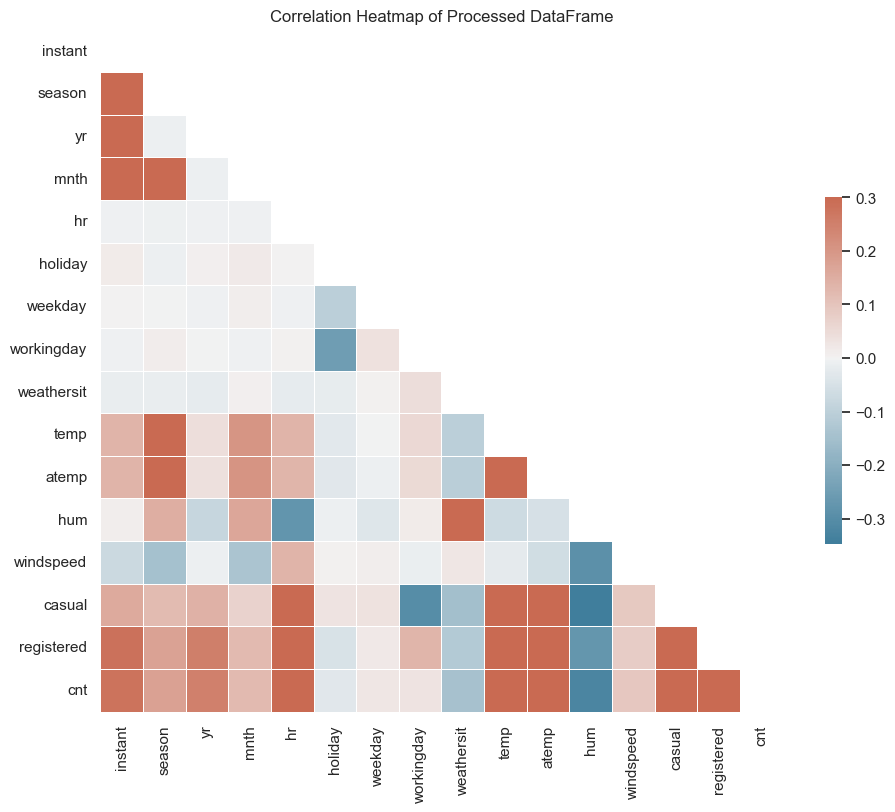

In [88]:
hour_raw_df_numeric = hour_raw_df.drop(['dteday'], axis = 1).apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

sns.set_theme(style="white")

corr = hour_raw_df_numeric.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Processed DataFrame')
plt.show()

## Feature Visualisations

### Year on Year Timeseries by Day Showing Notable Points
- Holidays marked dont seem to create much change, maybe the holiday data is wrong
- Some outliers detected fall around the same place each year, this could potentially be used in future years as a flag feature

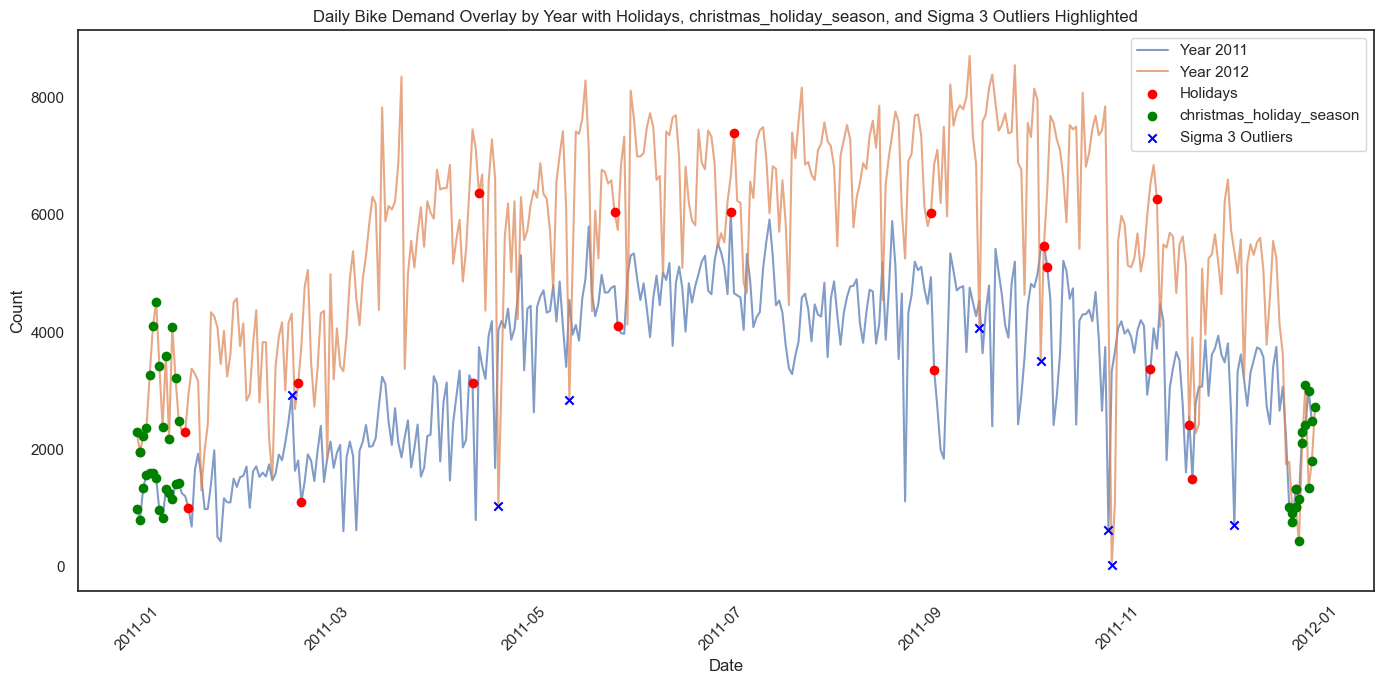

In [89]:
daily_counts = hour_processed_df.resample('D', on='timestamp').agg({
    'holiday': 'max',
    'christmas_holiday_season': 'max',
    'count': 'sum',
})

daily_counts.index = pd.to_datetime(daily_counts.index)

daily_counts['year'] = daily_counts.index.year

daily_counts['day_of_year'] = daily_counts.index.dayofyear
daily_counts['normalized_date'] = pd.to_datetime('2011-01-01') + pd.to_timedelta(daily_counts['day_of_year'] - 1, unit='D')

daily_counts = daily_counts.sort_values(['year', 'normalized_date'])

rolling_mean = daily_counts['count'].rolling(window=30, center=True).mean()
rolling_std = daily_counts['count'].rolling(window=30, center=True).std()

daily_counts['sigma_3_outlier'] = (daily_counts['count'] > rolling_mean + 3 * rolling_std) | (daily_counts['count'] < rolling_mean - 3 * rolling_std)

plt.figure(figsize=(14, 7))

for year in daily_counts['year'].unique():
    yearly_data = daily_counts[daily_counts['year'] == year]
    plt.plot(yearly_data['normalized_date'], yearly_data['count'], label=f'Year {year}', alpha=0.7)

holidays = daily_counts[daily_counts['holiday'] == 1]
plt.scatter(holidays['normalized_date'], holidays['count'], color='red', label='Holidays', zorder=5)

christmas_holiday_season = daily_counts[daily_counts['christmas_holiday_season'] == 1]
plt.scatter(christmas_holiday_season['normalized_date'], christmas_holiday_season['count'], color='green', label='christmas_holiday_season', marker='o', zorder=6)

sigma_3_outliers = daily_counts[daily_counts['sigma_3_outlier'] == True]
plt.scatter(sigma_3_outliers['normalized_date'], sigma_3_outliers['count'], color='blue', label='Sigma 3 Outliers', marker='x', zorder=7)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily Bike Demand Overlay by Year with Holidays, christmas_holiday_season, and Sigma 3 Outliers Highlighted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


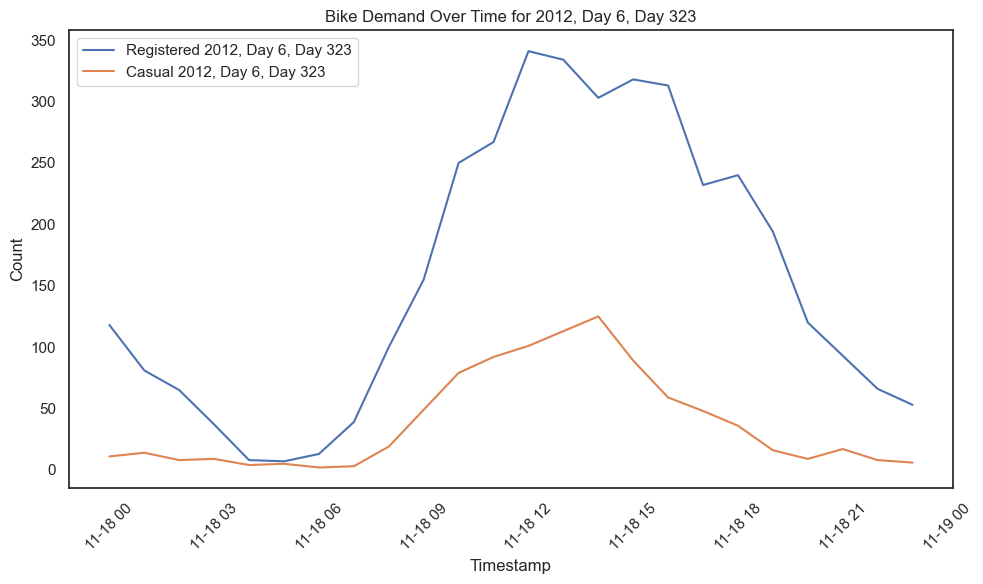

In [90]:
for _ in range(5):
    years = hour_processed_df['year'].unique()
    days_of_week = hour_processed_df['day_of_week'].unique()

    random_year = np.random.choice(years)
    random_day_of_week = np.random.choice(days_of_week)

    day_of_week_df = hour_processed_df[(hour_processed_df['year'] == random_year) & (hour_processed_df['day_of_week'] == random_day_of_week)]
    
    days = day_of_week_df['day'].unique()
    random_day = np.random.choice(days)
    
    day_df = day_of_week_df[day_of_week_df['day'] == random_day]

    plt.figure(figsize=(10, 6))
    plt.plot(day_df['timestamp'], day_df['registered'], label=f'Registered {random_year}, Day {random_day_of_week}, Day {random_day}')
    plt.plot(day_df['timestamp'], day_df['casual'], label=f'Casual {random_year}, Day {random_day_of_week}, Day {random_day}')

    plt.title(f'Bike Demand Over Time for {random_year}, Day {random_day_of_week}, Day {random_day}')
    plt.xlabel('Timestamp')
    plt.ylabel('Count')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    time.sleep(1)
    clear_output(wait=True)

## 

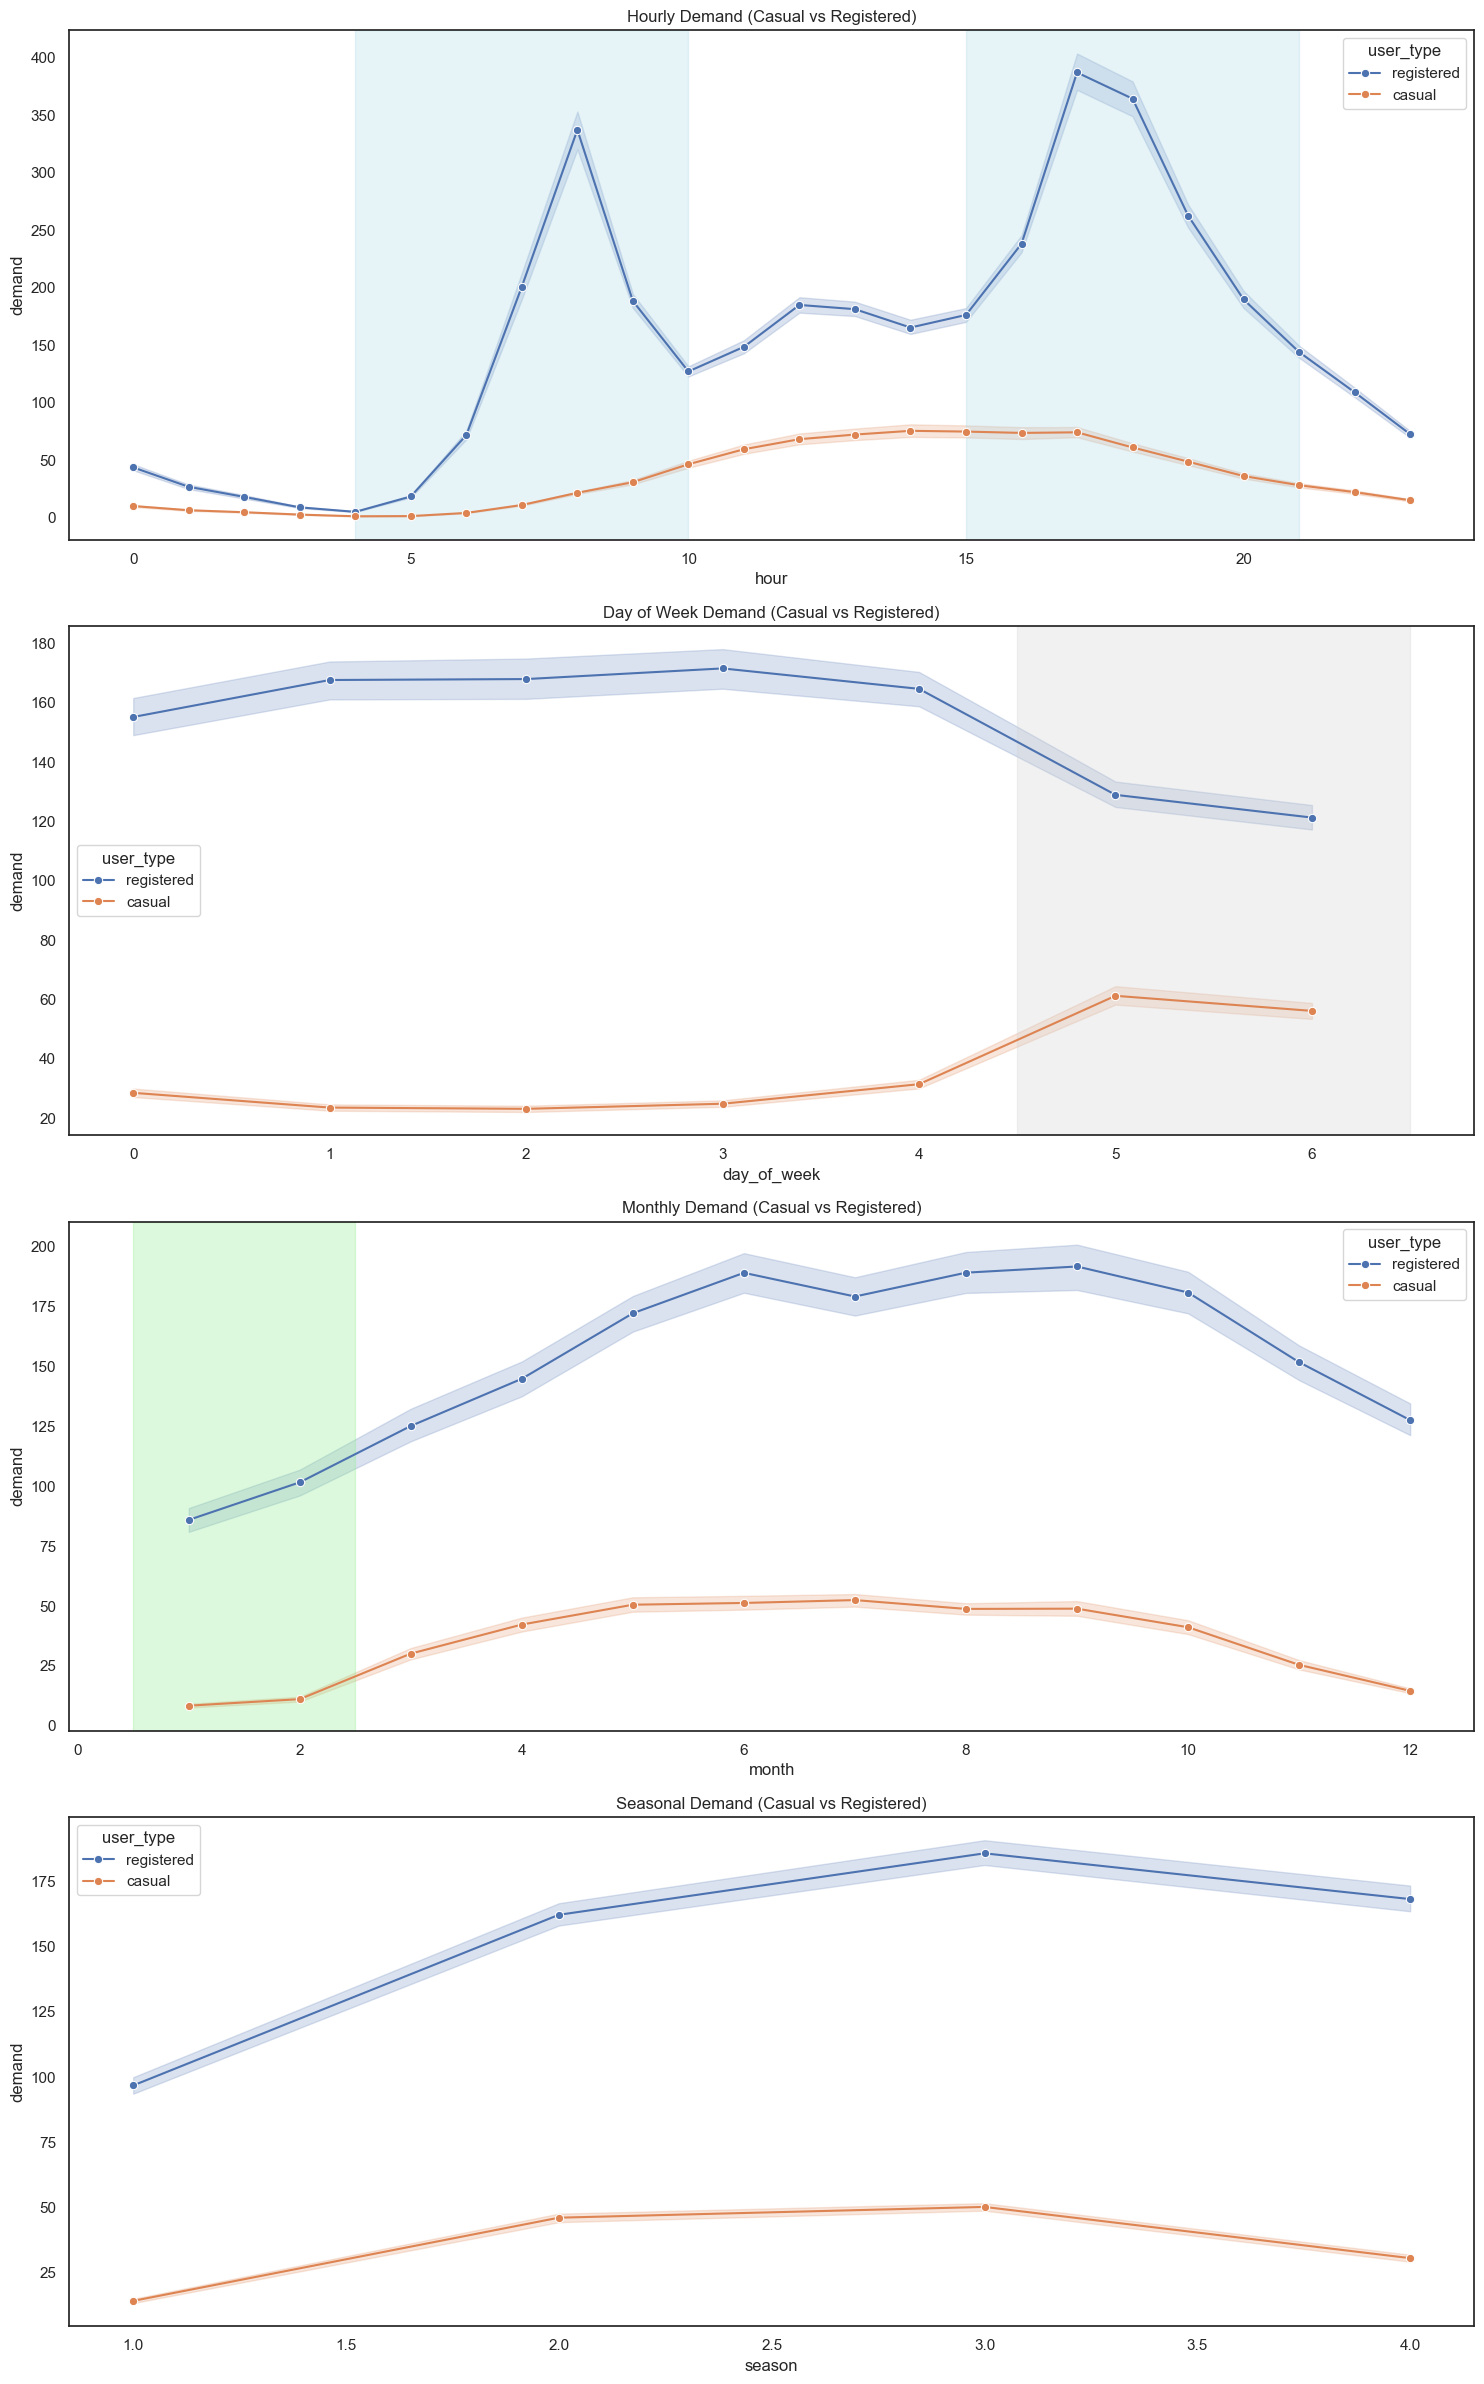

In [91]:
df_long = hour_processed_df.melt(
    id_vars=['day_of_week', 'month', 'season', 'hour', 'rush_hour'], 
    value_vars=['registered', 'casual'], 
    var_name='user_type', value_name='demand'
)

fig, axes = plt.subplots(4, 1, figsize=(15, 24))

sns.lineplot(x='hour', y='demand', hue='user_type', data=df_long, ax=axes[0], marker='o')
axes[0].set_title('Hourly Demand (Casual vs Registered)')
axes[0].axvspan(4, 10, color='lightblue', alpha=0.3)
axes[0].axvspan(15, 21, color='lightblue', alpha=0.3)

sns.lineplot(x='day_of_week', y='demand', hue='user_type', data=df_long, ax=axes[1], marker='o')
axes[1].set_title('Day of Week Demand (Casual vs Registered)')
axes[1].axvspan(4.5, 6.5, color='lightgrey', alpha=0.3)

sns.lineplot(x='month', y='demand', hue='user_type', data=df_long, ax=axes[2], marker='o')
axes[2].set_title('Monthly Demand (Casual vs Registered)')
axes[2].axvspan(0.5, 2.5, color='lightgreen', alpha=0.3)

sns.lineplot(x='season', y='demand', hue='user_type', data=df_long, ax=axes[3], marker='o')
axes[3].set_title('Seasonal Demand (Casual vs Registered)')

plt.tight_layout()
plt.show()


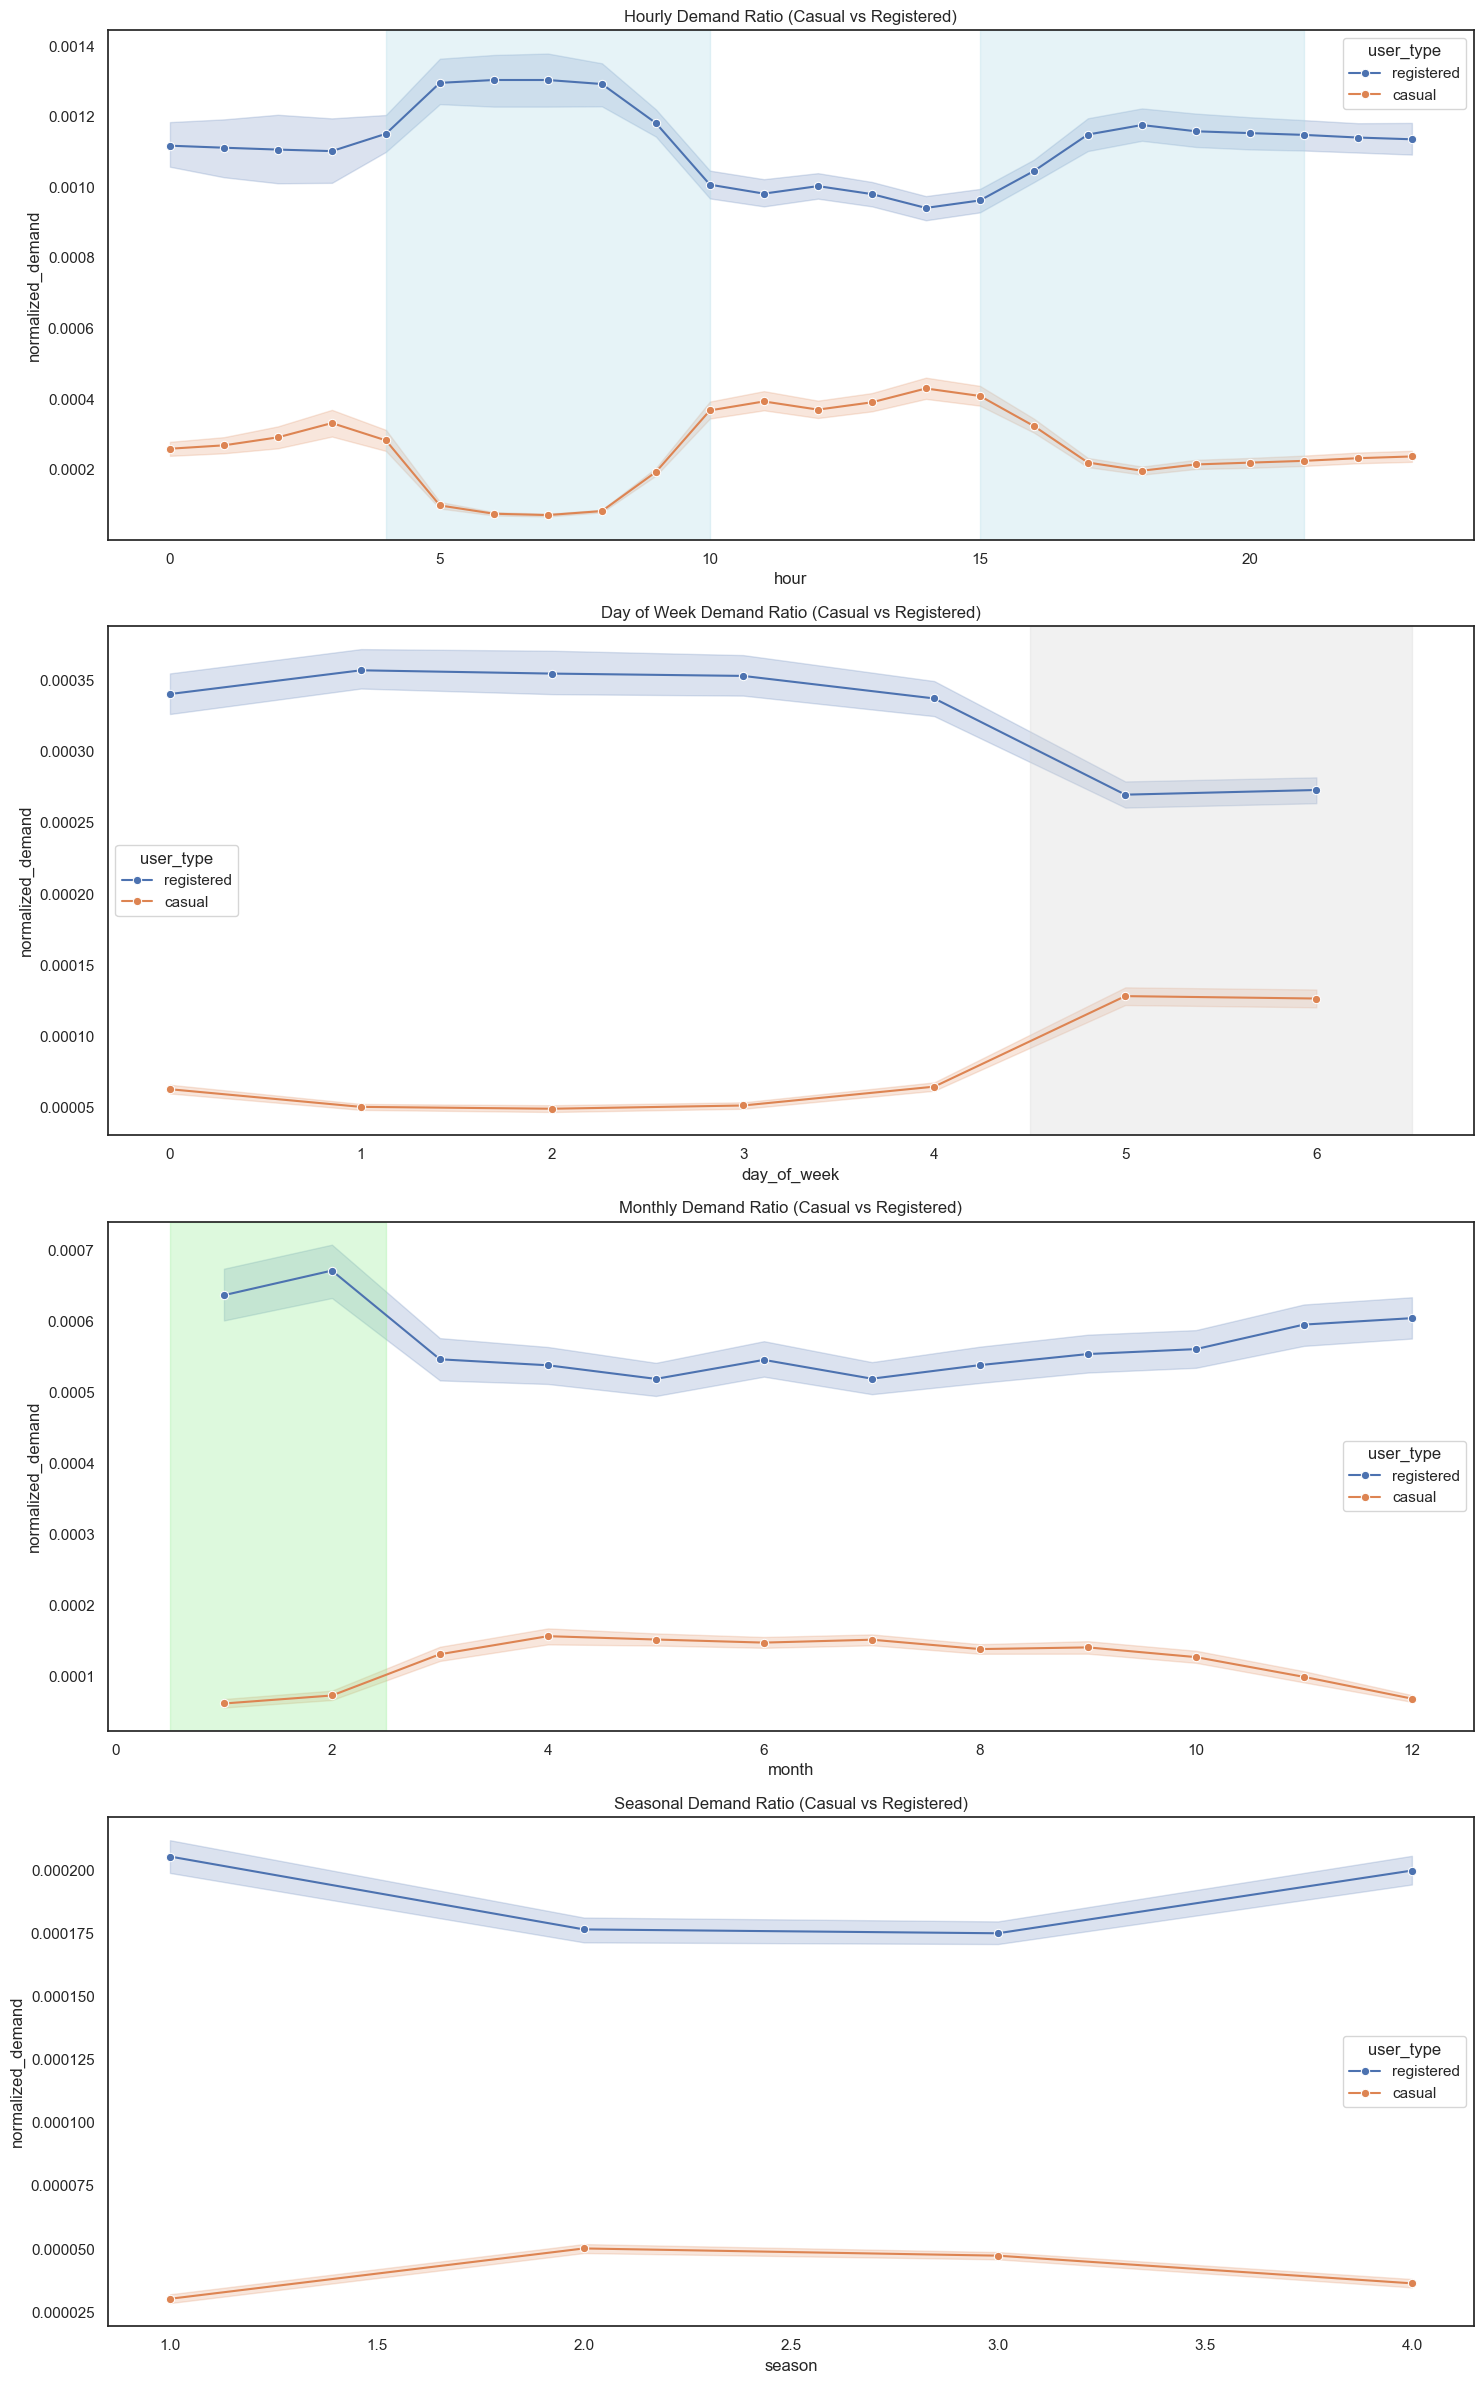

In [ ]:
df_long = hour_processed_df.melt(
    id_vars=['day_of_week', 'month', 'season', 'hour', 'rush_hour'], 
    value_vars=['registered', 'casual'], 
    var_name='user_type', value_name='demand'
)

fig, axes = plt.subplots(4, 1, figsize=(15, 24))

df_hour = df_long.copy()
df_hour['normalized_demand'] = df_hour.groupby('hour')['demand'].transform(lambda x: x / x.sum())
sns.lineplot(x='hour', y='normalized_demand', hue='user_type', data=df_hour, ax=axes[0], marker='o')
axes[0].set_title('Hourly Demand Ratio (Casual vs Registered)')
# Highlight rush hour periods (6–10 and 15–20)
axes[0].axvspan(4, 10, color='lightblue', alpha=0.3)
axes[0].axvspan(15, 21, color='lightblue', alpha=0.3)

df_day = df_long.copy()
df_day['normalized_demand'] = df_day.groupby('day_of_week')['demand'].transform(lambda x: x / x.sum())
sns.lineplot(x='day_of_week', y='normalized_demand', hue='user_type', data=df_day, ax=axes[1], marker='o')
axes[1].set_title('Day of Week Demand Ratio (Casual vs Registered)')
# Highlight weekend days (assumed day_of_week 5 and 6 if Monday=0)
axes[1].axvspan(4.5, 6.5, color='lightgrey', alpha=0.3)

df_month = df_long.copy()
df_month['normalized_demand'] = df_month.groupby('month')['demand'].transform(lambda x: x / x.sum())
sns.lineplot(x='month', y='normalized_demand', hue='user_type', data=df_month, ax=axes[2], marker='o')
axes[2].set_title('Monthly Demand Ratio (Casual vs Registered)')
# Highlight months 1 and 2 (adjust the range from 0.5 to 2.5)
axes[2].axvspan(0.5, 2.5, color='lightgreen', alpha=0.3)

df_season = df_long.copy()
df_season['normalized_demand'] = df_season.groupby('season')['demand'].transform(lambda x: x / x.sum())
sns.lineplot(x='season', y='normalized_demand', hue='user_type', data=df_season, ax=axes[3], marker='o')
axes[3].set_title('Seasonal Demand Ratio (Casual vs Registered)')

plt.tight_layout()
plt.show()


## Distribution of the Count

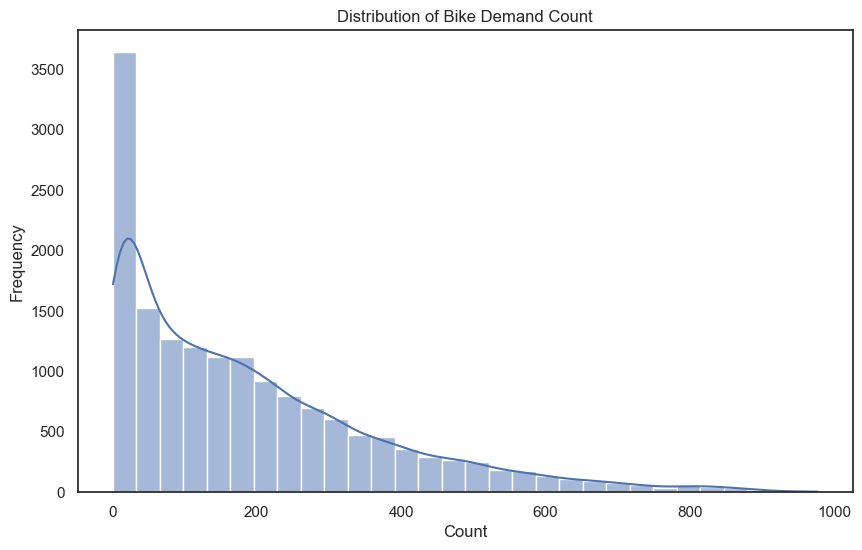

In [93]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['count'], bins=30, kde=True)
plt.title('Distribution of Bike Demand Count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

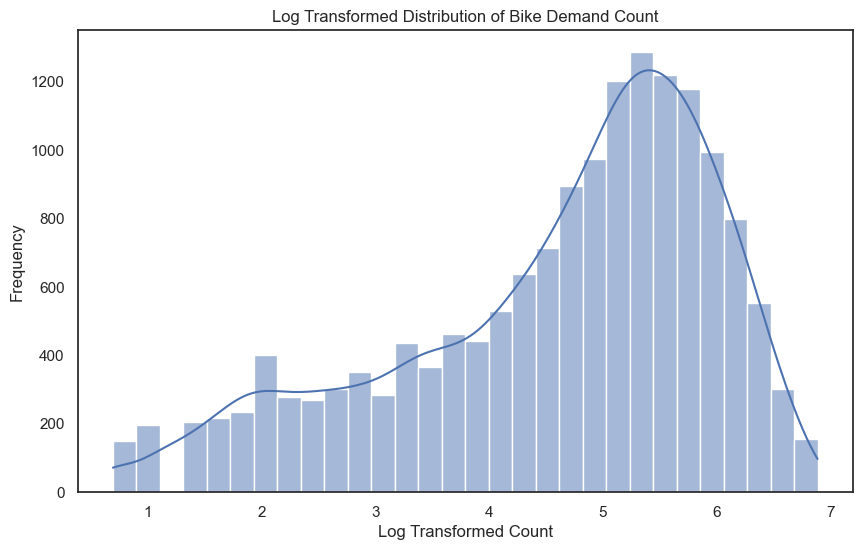

In [94]:
count_log = np.log1p(train_df['count'])  # Use log1p to handle zero values

plt.figure(figsize=(10, 6))
sns.histplot(count_log, bins=30, kde=True)
plt.title('Log Transformed Distribution of Bike Demand Count')
plt.xlabel('Log Transformed Count')
plt.ylabel('Frequency')
plt.show()

### Why Box-Cox Transformation Over Log1p?

The Box-Cox transformation was chosen over the log1p transformation for the following reasons:

1. **Flexibility**: The Box-Cox transformation is more flexible as it includes a parameter (lambda) that can be optimized to best normalize the data. This allows it to handle a wider range of data distributions compared to the log1p transformation, which is fixed.

2. **Improved Normality**: The Box-Cox transformation often results in a distribution that is closer to normality compared to log1p. This is particularly important for linear models and other statistical methods that assume normally distributed errors.

3. **Variance Stabilisation**: Box-Cox can stabilise variance across the data, which can improve the performance of regression models by making the relationship between variables more linear and homoscedastic.

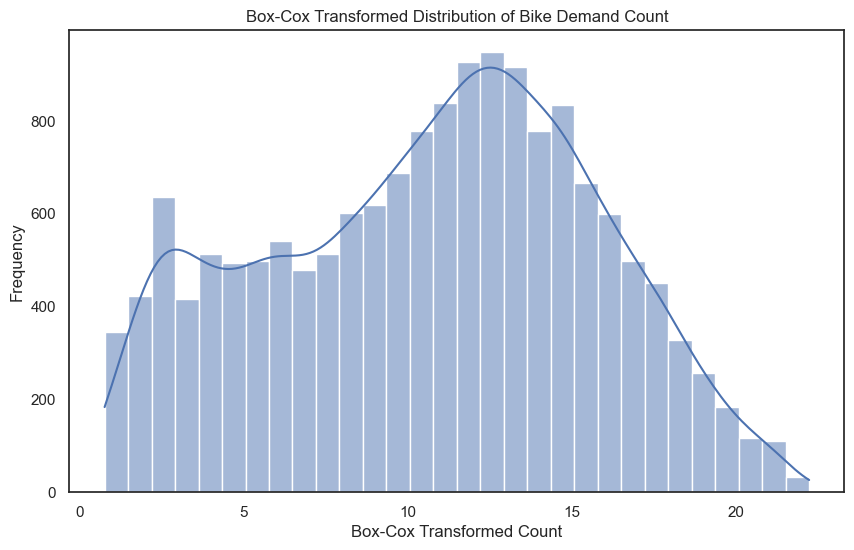

In [95]:
count_boxcox, _ = boxcox(train_df['count'] + 1)

plt.figure(figsize=(10, 6))
sns.histplot(count_boxcox, bins=30, kde=True)
plt.title('Box-Cox Transformed Distribution of Bike Demand Count')
plt.xlabel('Box-Cox Transformed Count')
plt.ylabel('Frequency')
plt.show()

C:\Users\Lawrence\AppData\Local\Temp\ipykernel_22560\2672998001.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



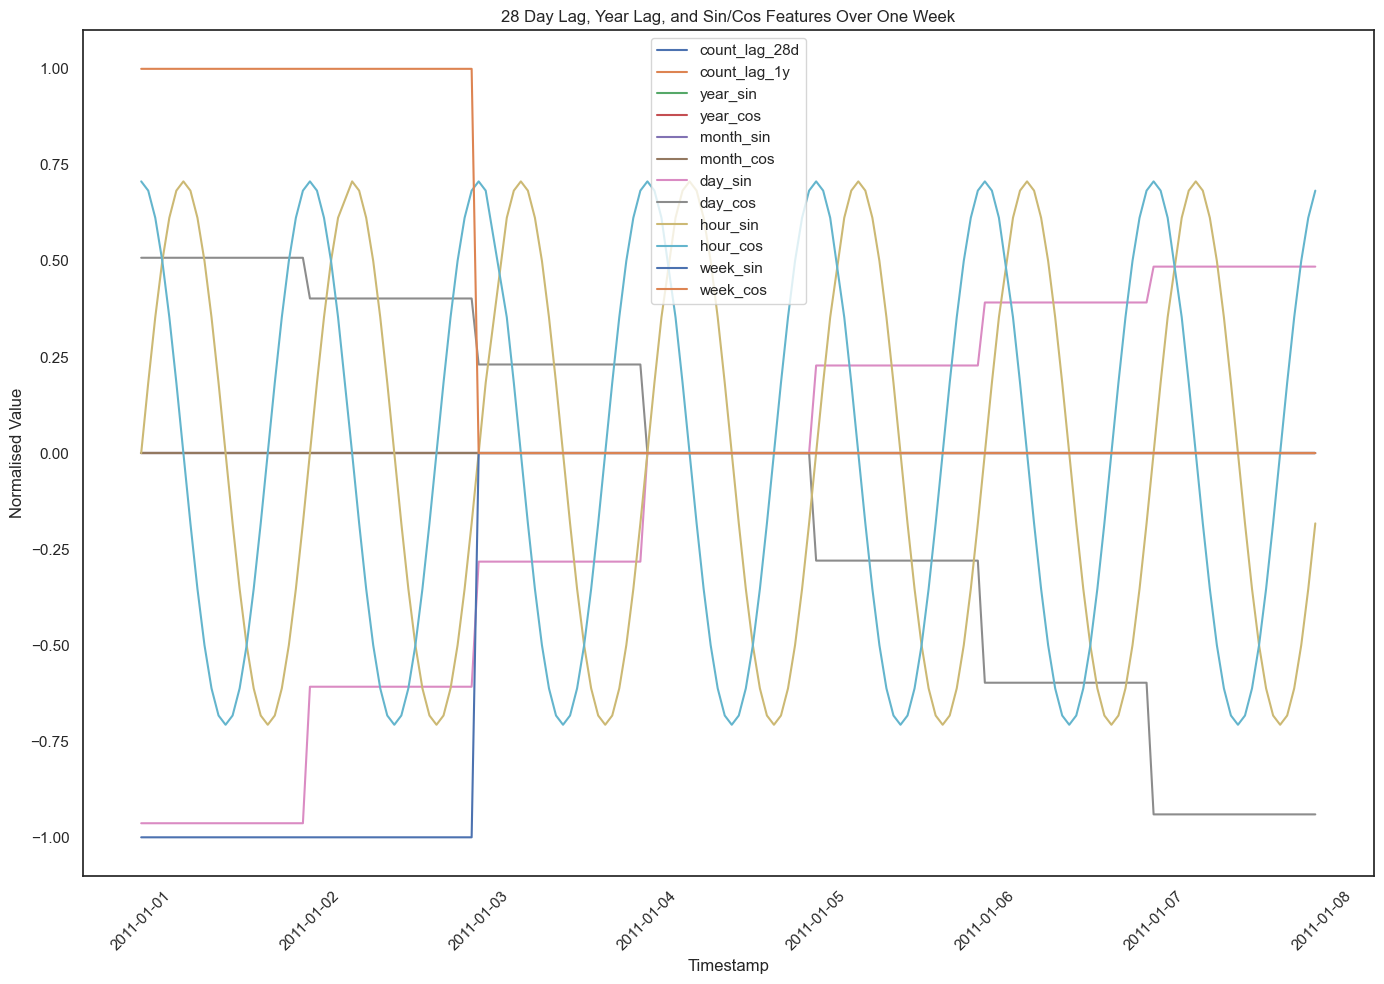

In [96]:
one_week_data = train_df[(train_df['timestamp'] >= '2011-01-01') & (train_df['timestamp'] < '2011-01-08')]

features_to_plot = ['count_lag_28d', 'count_lag_1y', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos']

scaler = RobustScaler()
one_week_data[features_to_plot] = scaler.fit_transform(one_week_data[features_to_plot])

plt.figure(figsize=(14, 10))

for feature in features_to_plot:
    plt.plot(one_week_data['timestamp'], one_week_data[feature], label=feature)

plt.xlabel('Timestamp')
plt.ylabel('Normalised Value')
plt.title('28 Day Lag, Year Lag, and Sin/Cos Features Over One Week')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Looking at some more splits of the data by working and non-working day

2025-03-11 20:59:59,547 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-11 20:59:59,556 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-11 20:59:59,634 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-11 20:59:59,642 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-11 20:59:59,788 - INFO - Using categorical units to plot a list of strings that are all parsable as 

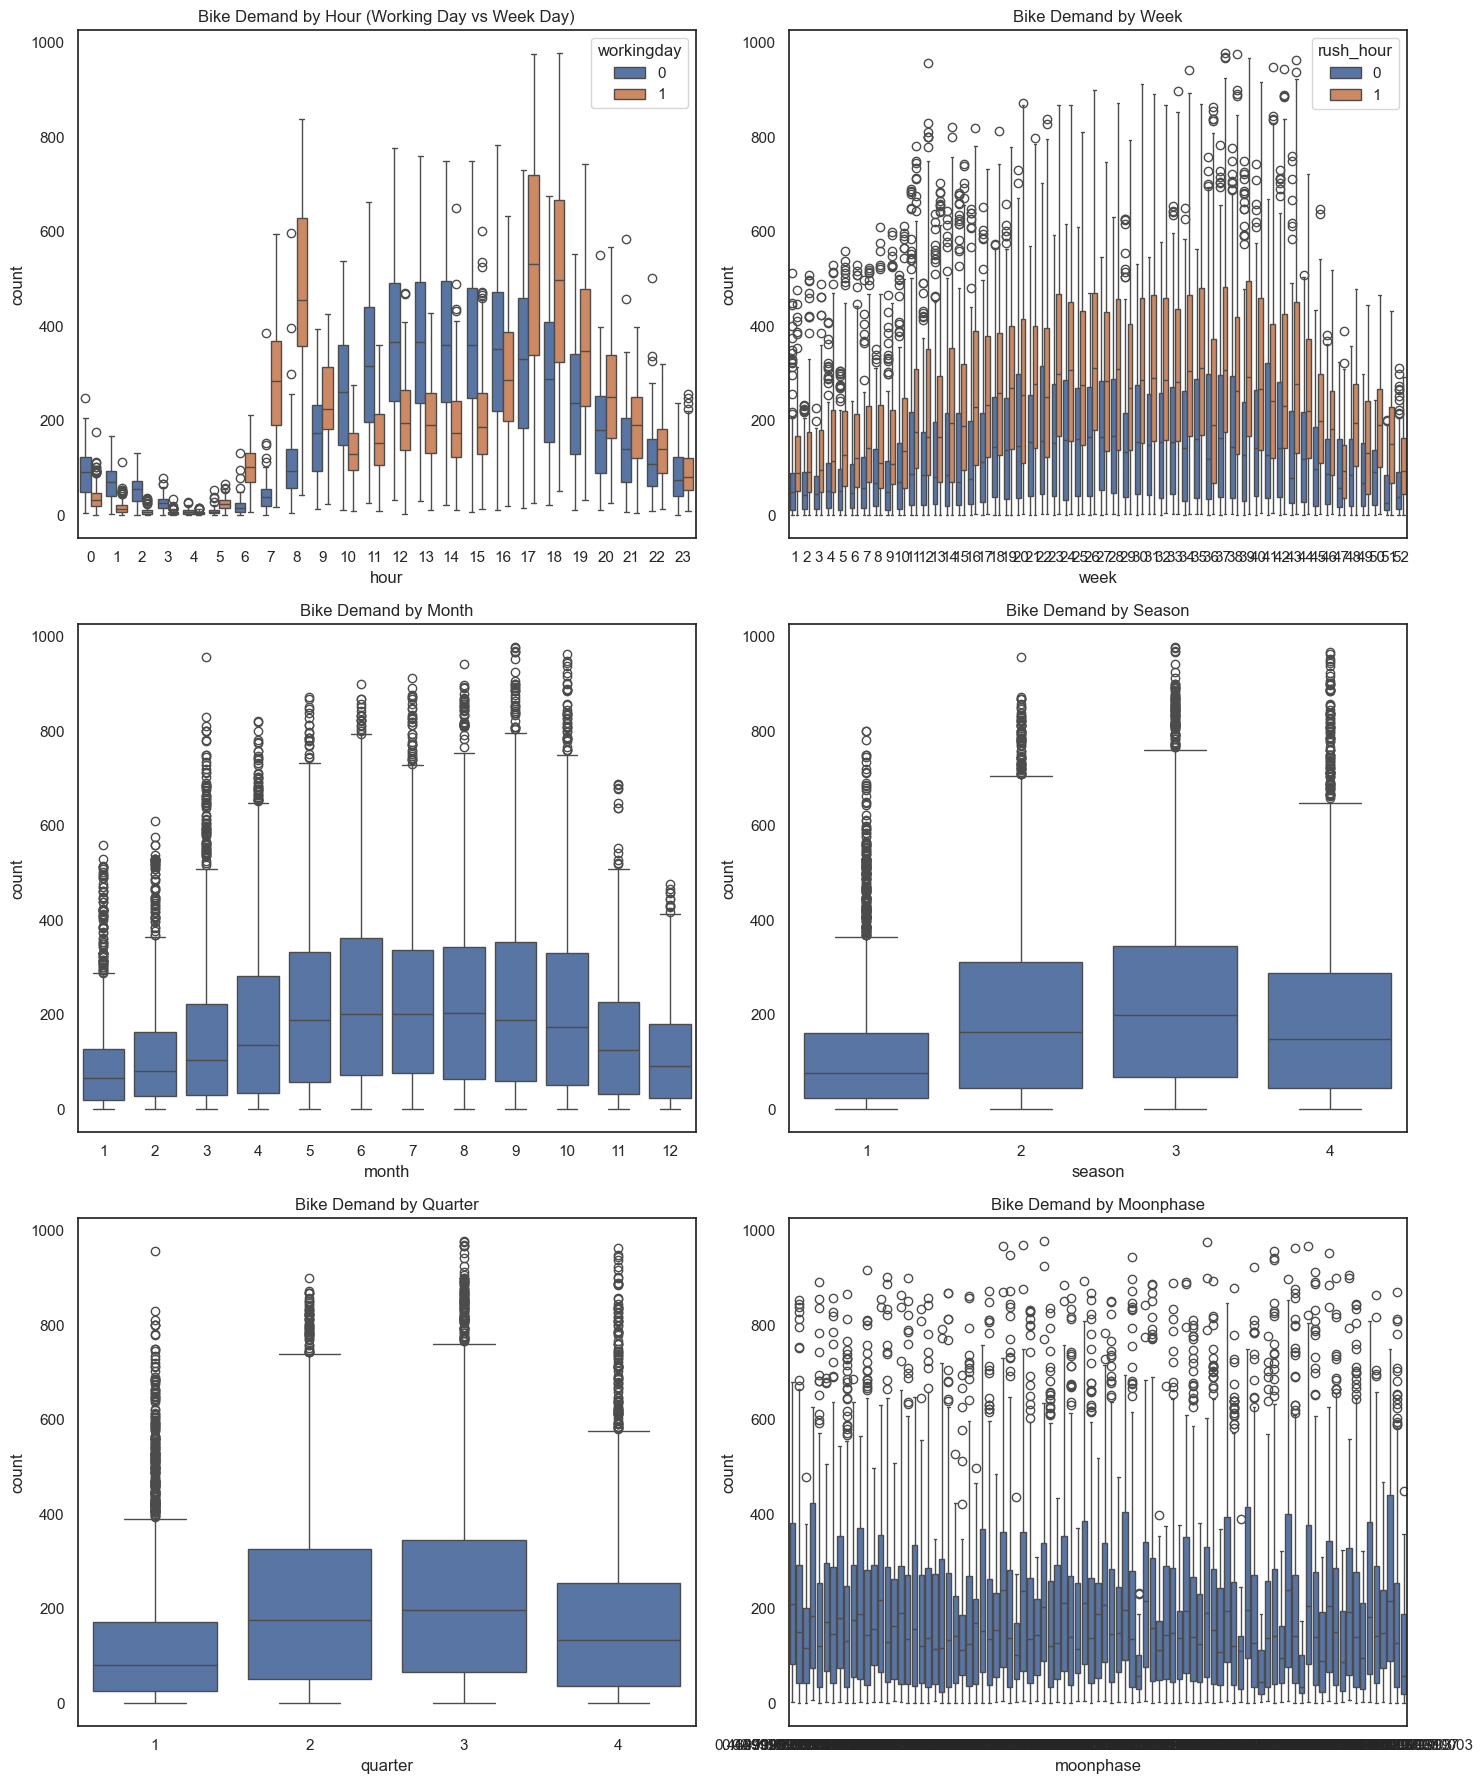

In [97]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

sns.boxplot(x='hour', y='count', hue='workingday', data=train_df, ax=axes[0, 0])
axes[0, 0].set_title('Bike Demand by Hour (Working Day vs Week Day)')

sns.boxplot(x='week', y='count', hue='rush_hour', data=train_df, ax=axes[0, 1])
axes[0, 1].set_title('Bike Demand by Week')

sns.boxplot(x='month', y='count', data=train_df, ax=axes[1, 0])
axes[1, 0].set_title('Bike Demand by Month')

sns.boxplot(x='season', y='count', data=train_df, ax=axes[1, 1])
axes[1, 1].set_title('Bike Demand by Season')

sns.boxplot(x='quarter', y='count', data=train_df, ax=axes[2, 0])
axes[2, 0].set_title('Bike Demand by Quarter')

sns.boxplot(x='moonphase', y='count', data=train_df, ax=axes[2, 1])
axes[2, 1].set_title('Bike Demand by Moonphase')

plt.tight_layout()
plt.show()

Some trends are noticebale in the weather and season data, and possibly some outliers that could be removed.

2025-03-11 21:00:00,895 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-11 21:00:00,903 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


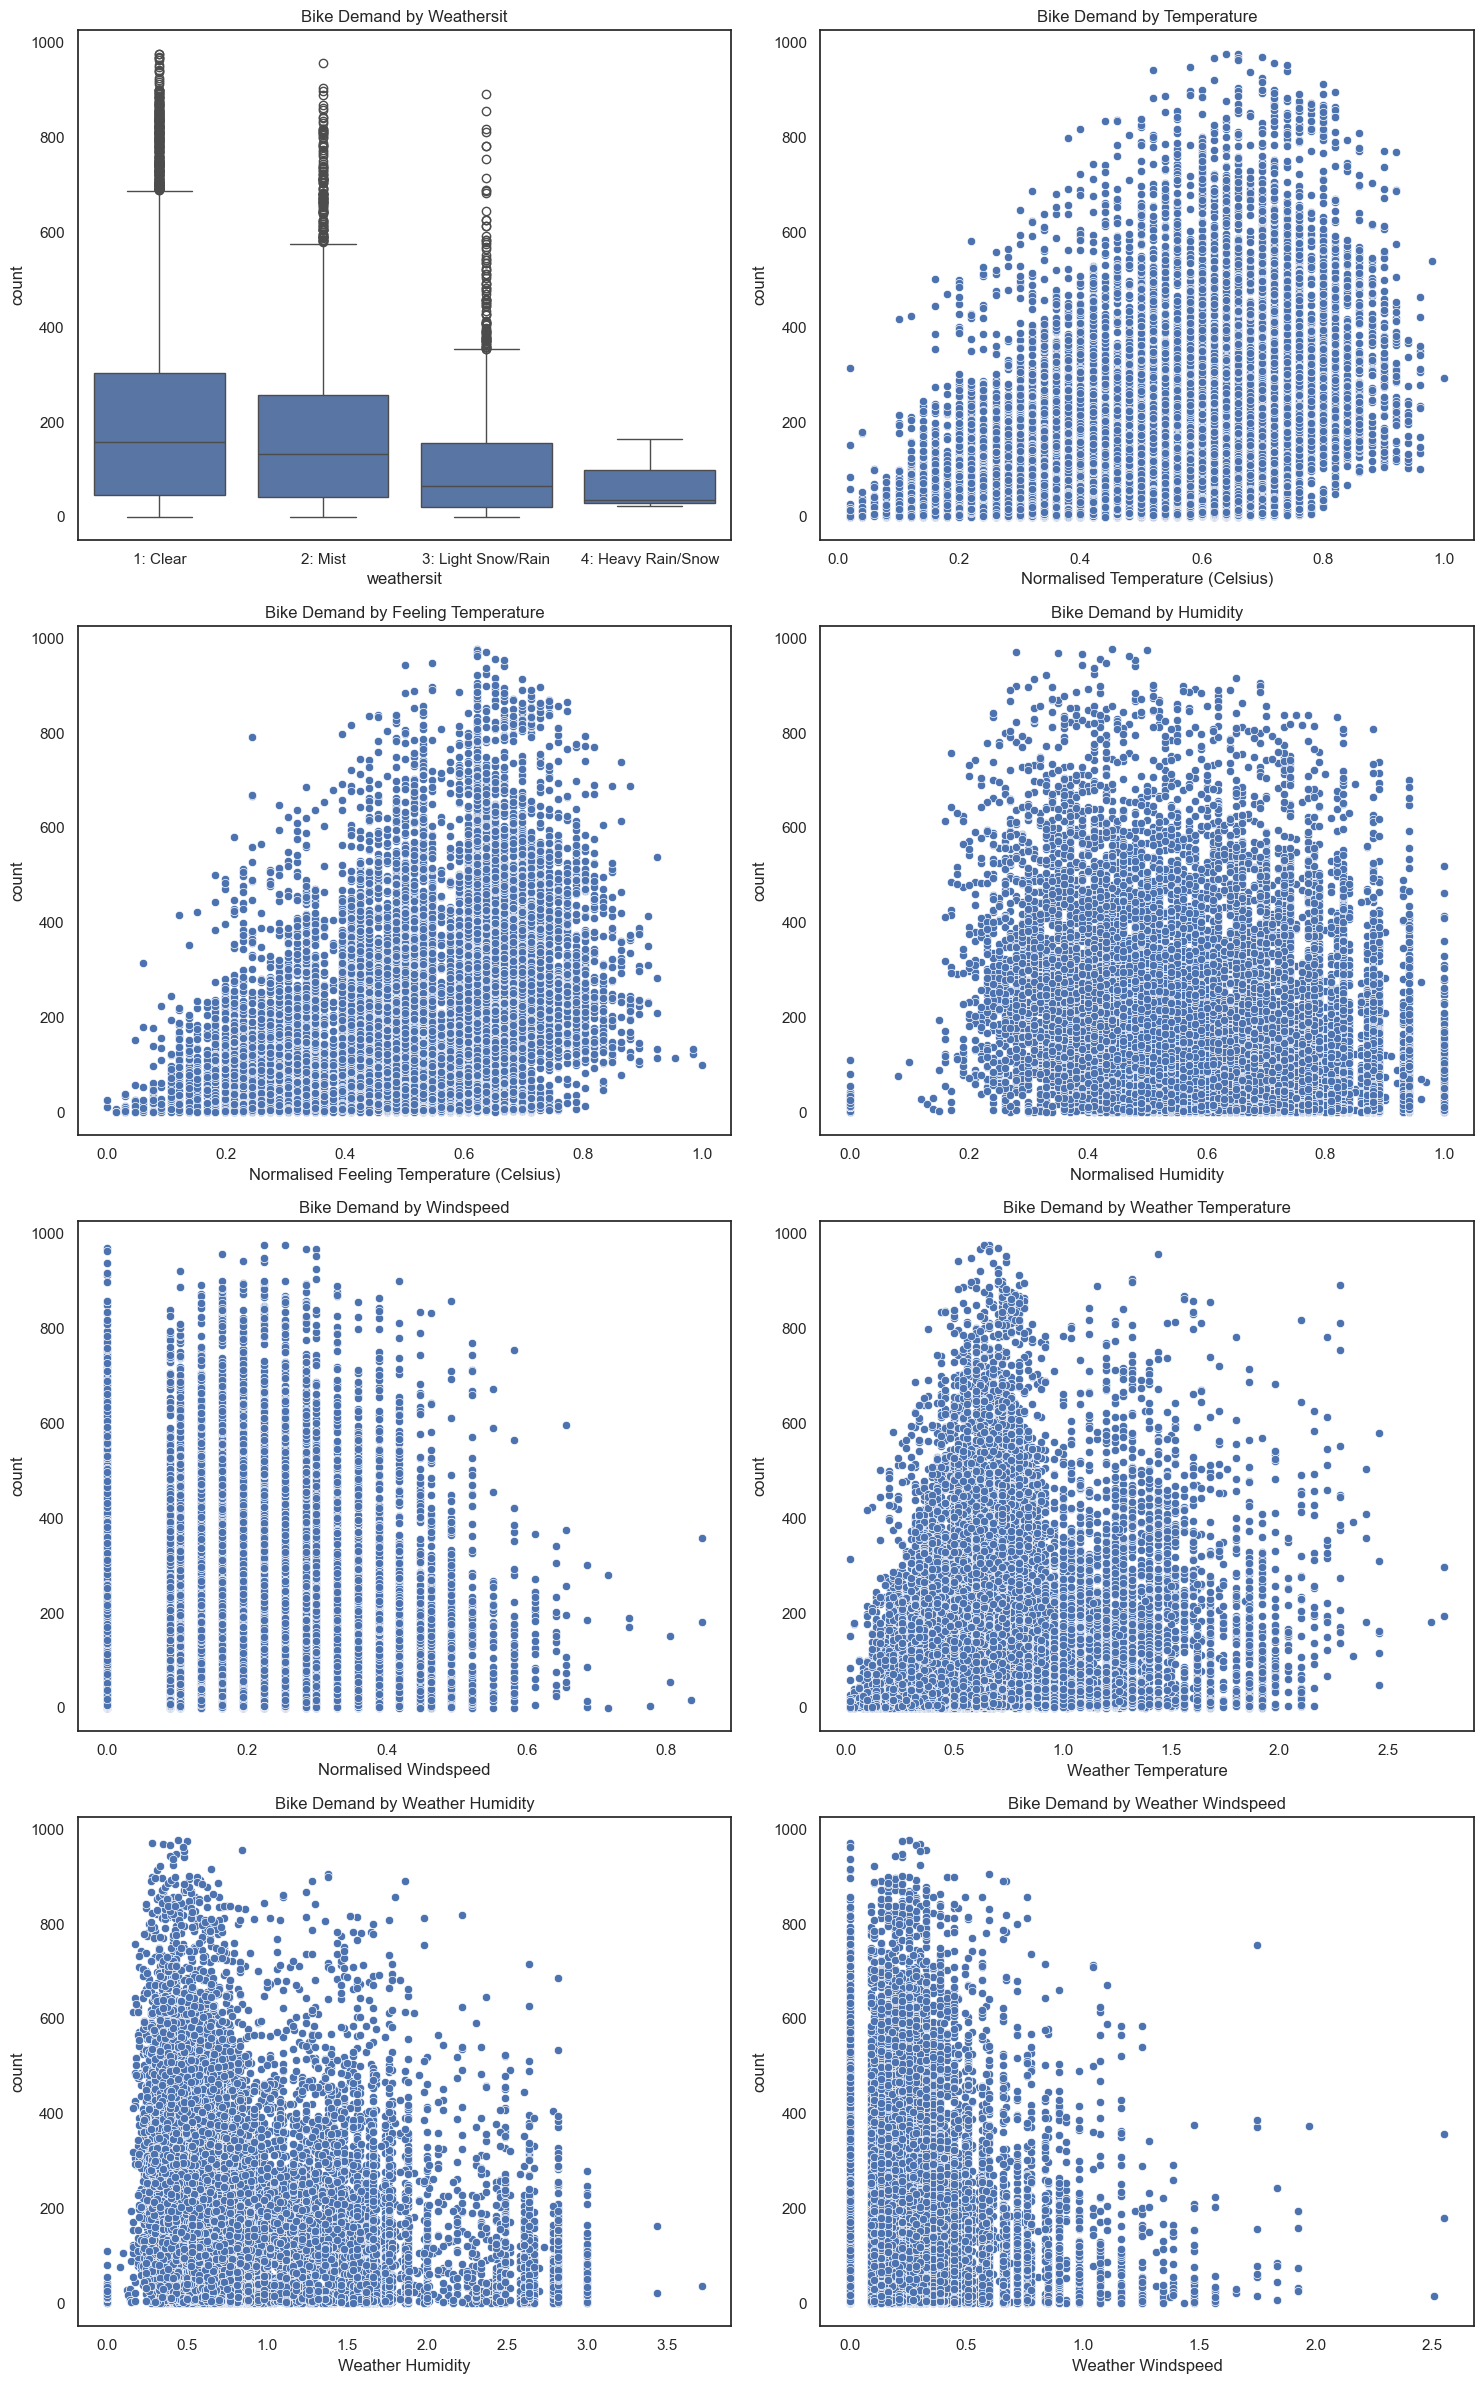

In [98]:
fig, axes = plt.subplots(4, 2, figsize=(15, 24))

sns.boxplot(x='weathersit', y='count', data=train_df, ax=axes[0, 0])
axes[0, 0].set_title('Bike Demand by Weathersit')
axes[0, 0].set_xticks([0, 1, 2, 3])
axes[0, 0].set_xticklabels(['1: Clear', '2: Mist', '3: Light Snow/Rain', '4: Heavy Rain/Snow'])

sns.scatterplot(x='temp', y='count', data=train_df, ax=axes[0, 1])
axes[0, 1].set_title('Bike Demand by Temperature')
axes[0, 1].set_xlabel('Normalised Temperature (Celsius)')

sns.scatterplot(x='atemp', y='count', data=train_df, ax=axes[1, 0])
axes[1, 0].set_title('Bike Demand by Feeling Temperature')
axes[1, 0].set_xlabel('Normalised Feeling Temperature (Celsius)')

sns.scatterplot(x='hum', y='count', data=train_df, ax=axes[1, 1])
axes[1, 1].set_title('Bike Demand by Humidity')
axes[1, 1].set_xlabel('Normalised Humidity')

sns.scatterplot(x='windspeed', y='count', data=train_df, ax=axes[2, 0])
axes[2, 0].set_title('Bike Demand by Windspeed')
axes[2, 0].set_xlabel('Normalised Windspeed')

sns.scatterplot(x='weather_temp', y='count', data=train_df, ax=axes[2, 1])
axes[2, 1].set_title('Bike Demand by Weather Temperature')
axes[2, 1].set_xlabel('Weather Temperature')

sns.scatterplot(x='weather_hum', y='count', data=train_df, ax=axes[3, 0])
axes[3, 0].set_title('Bike Demand by Weather Humidity')
axes[3, 0].set_xlabel('Weather Humidity')

sns.scatterplot(x='weather_windspeed', y='count', data=train_df, ax=axes[3, 1])
axes[3, 1].set_title('Bike Demand by Weather Windspeed')
axes[3, 1].set_xlabel('Weather Windspeed')

plt.tight_layout()
plt.show()

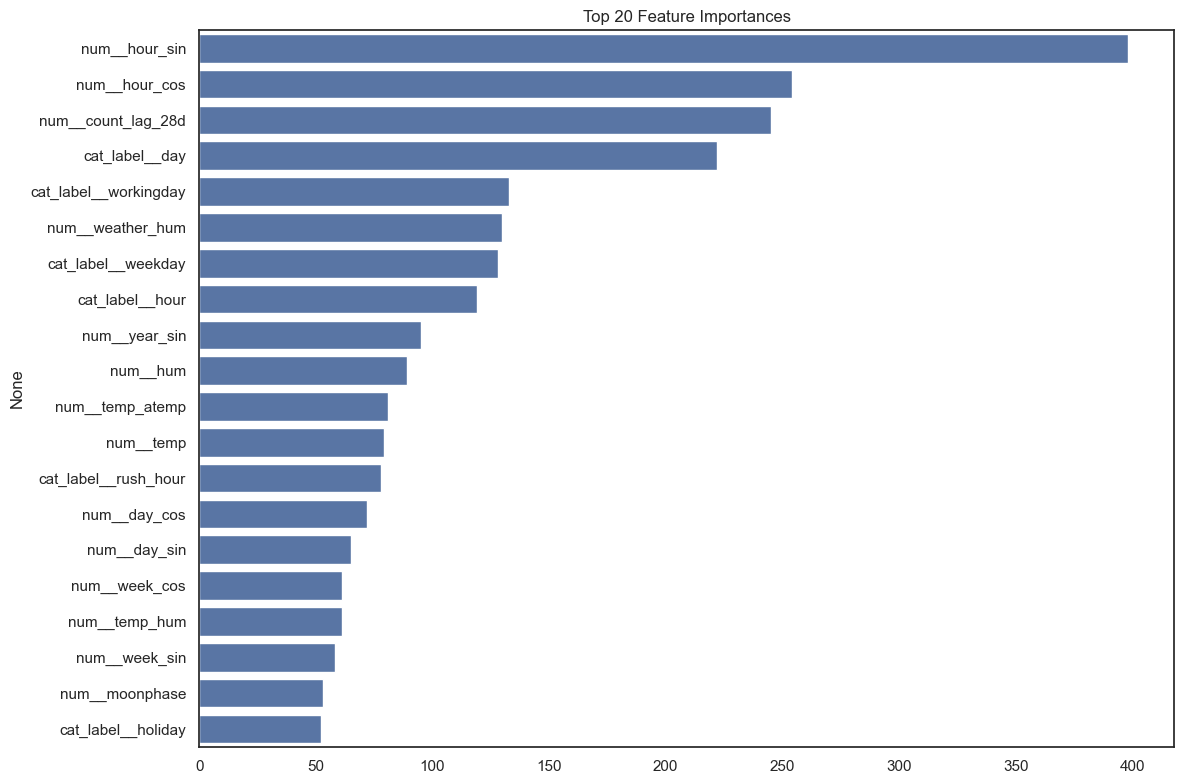

In [99]:
full_features = ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'count', 'day',
       'day_of_week', 'day_of_month', 'week', 'year_sin', 'year_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos',
       'week_sin', 'week_cos', 'working_day', 'weekend', 'is_monday',
       'is_friday', 'moonphase', 'quarter', 'christmas_holiday_season',
       'summer_season', 'spring_season', 'fall_season', 'winter_season',
       'day_of_year', 'is_business_hours', 'is_night', 'rush_hour',
       'hum_windspeed', 'temp_hum', 'temp_windspeed', 'windspeed_squared',
       'hum_squared', 'weather_temp', 'weather_hum', 'weather_windspeed',
       'atemp_hum', 'atemp_windspeed', 'atemp_squared', 'temp_atemp',
       'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio',
       'hour_ratio', 'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio',
       'month_ratio', 'season_ratio', 'sigma_3_outlier', 'count_lag_28d', 'count_lag_1y']

numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 
                   'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'hum_windspeed', 
                   'temp_hum', 'temp_windspeed', 'windspeed_squared', 'hum_squared', 'weather_temp', 
                   'weather_hum', 'weather_windspeed', 'atemp_hum', 'atemp_windspeed', 'atemp_squared', 
                   'temp_atemp', 'weather_atemp', 'temp_atemp_diff', 'total_registered_ratio', 'hour_ratio', 
                   'day_ratio', 'working_day_or_weekend_ratio', 'week_ratio', 'month_ratio', 'season_ratio', 'moonphase', 'count_lag_28d', 'count_lag_1y']

categorical_label_encode_columns = ['hour', 'year', 'day', 'season', 'holiday', 'weekday', 'workingday', 'weathersit', 'working_day', 'weekend', 
                                    'is_monday', 'is_friday', 'christmas_holiday_season', 
                                    'summer_season', 'spring_season', 'fall_season', 'winter_season', 'is_night', 'rush_hour', 'is_business_hours', 'sigma_3_outlier']

categorical_one_hot_columns = ['quarter', 'day_of_week']

numeric_columns = [col for col in numeric_columns if col in full_features]
categorical_label_encode_columns = [col for col in categorical_label_encode_columns if col in full_features]
categorical_one_hot_columns = [col for col in categorical_one_hot_columns if col in full_features]

features = numeric_columns + categorical_label_encode_columns + categorical_one_hot_columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_onehot_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

categorical_label_transformer = Pipeline([
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat_label", categorical_label_transformer, categorical_label_encode_columns),
        ("cat_onehot", categorical_onehot_transformer, categorical_one_hot_columns)
    ],
    remainder='drop',
    n_jobs=-1
)

X_train = train_df.drop(columns=['count'])
X_train_processed = preprocessor.fit_transform(X_train)
y_train = train_df['count']

y_train, lambda_value = boxcox(y_train + 1)
new_column_names = preprocessor.get_feature_names_out()

model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42, verbose=-1)

model.fit(X_train_processed, y_train)

importances = pd.Series(model.feature_importances_, index=new_column_names)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=importances.values[:20], y=importances.index[:20])
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()


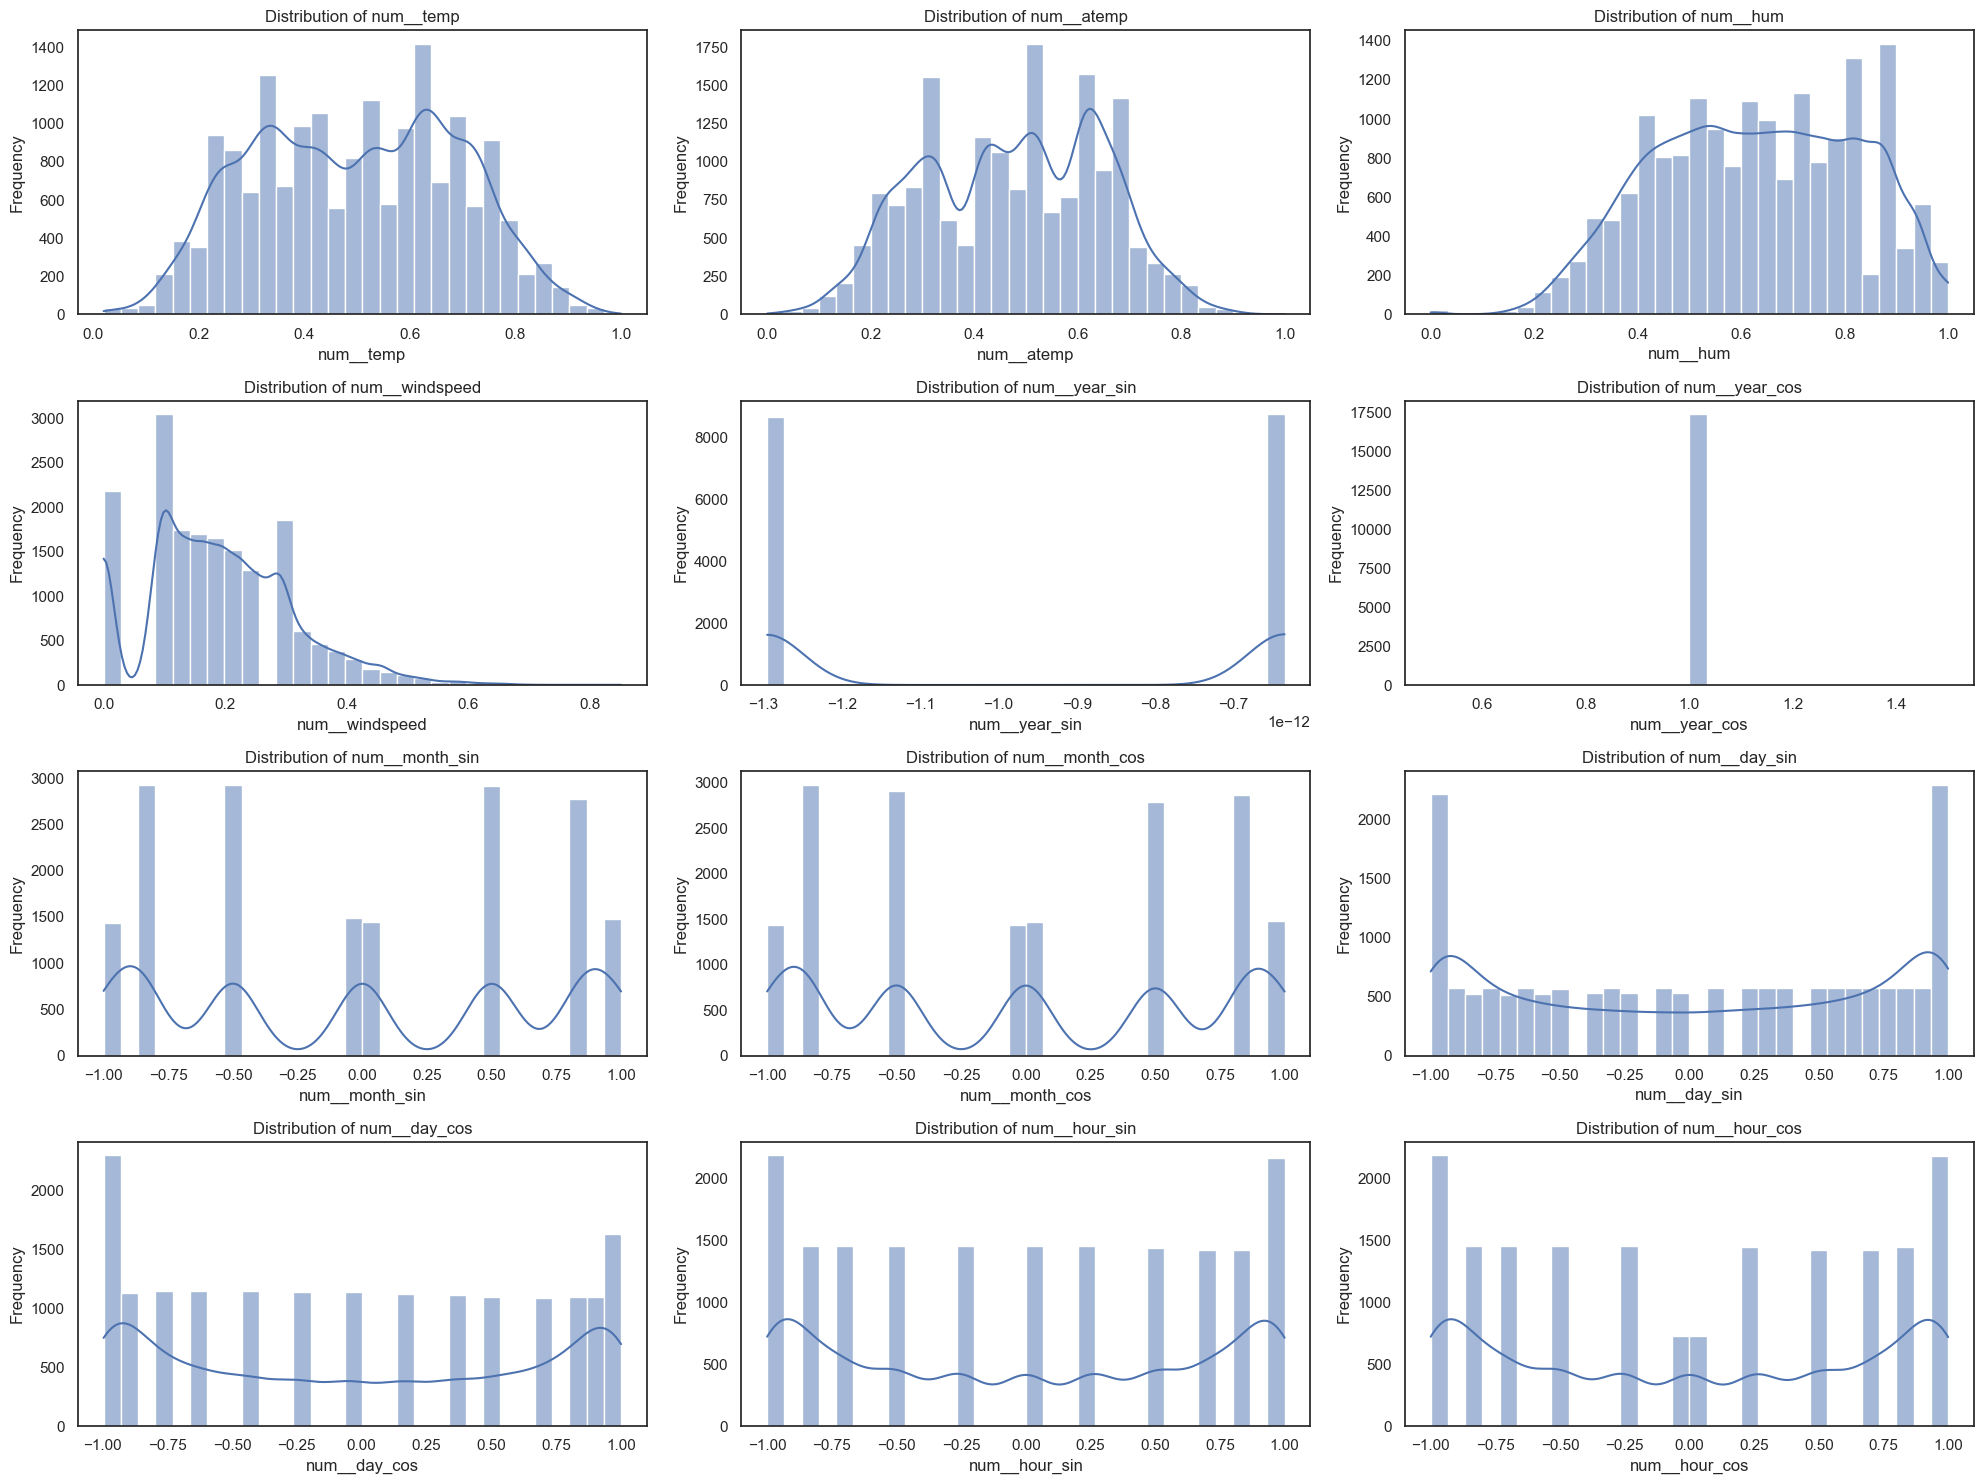

In [100]:
new_columns = new_column_names[:12]  # Limit to 12 columns

plt.figure(figsize=(20, 15))
for i, column in enumerate(new_columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(hour_processed_df[column.split('__')[1]], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Root Mean Squared Error: 70.75
R^2 Score: 0.8465


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



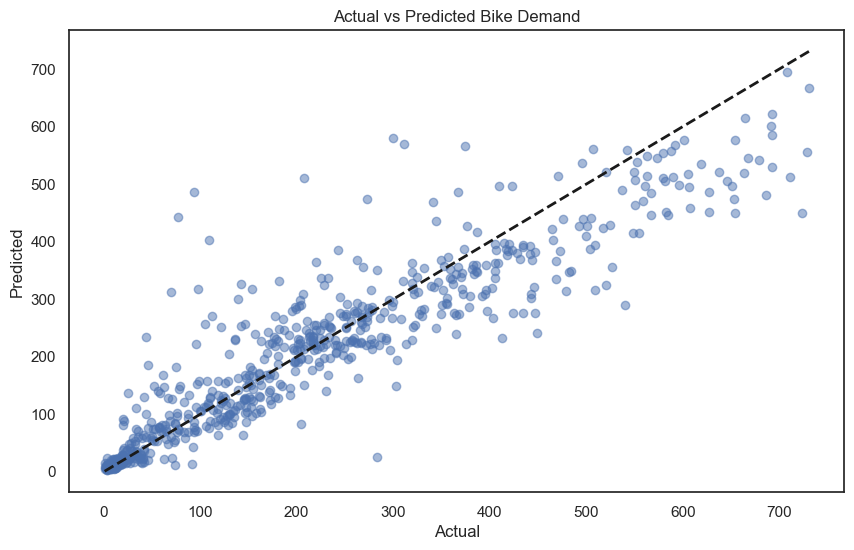

In [101]:
X_val = val_df.drop(columns=['count'])
X_val_processed = preprocessor.transform(X_val)

y_val = val_df['count']
y_pred = inverse_boxcox(model.predict(X_val_processed), lambda_value)

rmse = mean_squared_error(y_val, y_pred) ** 0.5
r2 = r2_score(y_val, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Bike Demand')
plt.show()

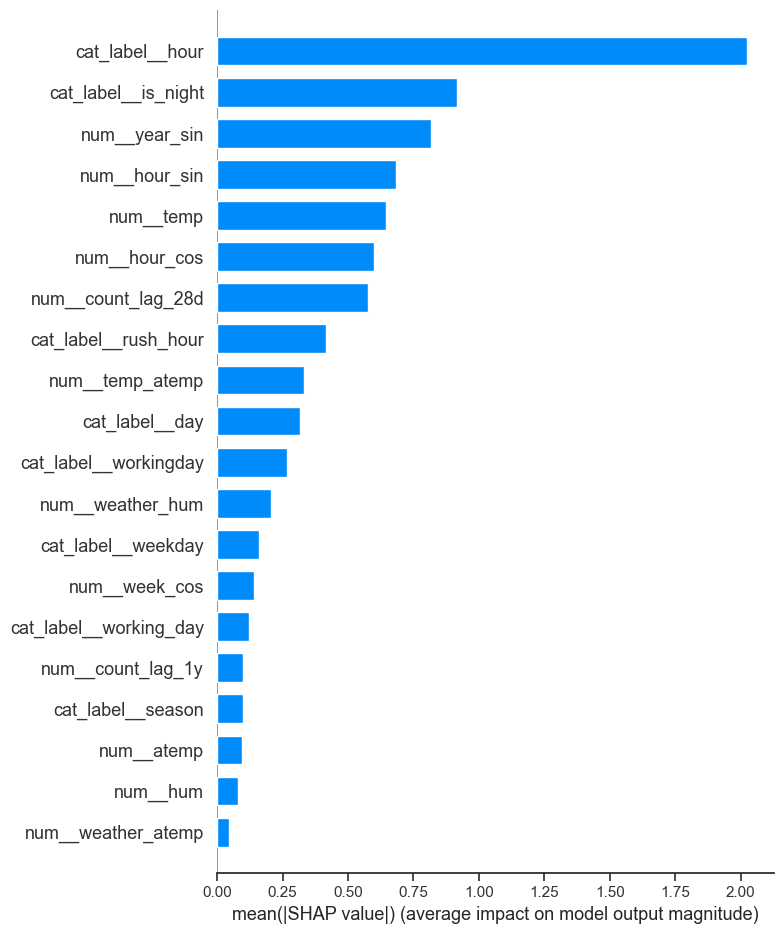

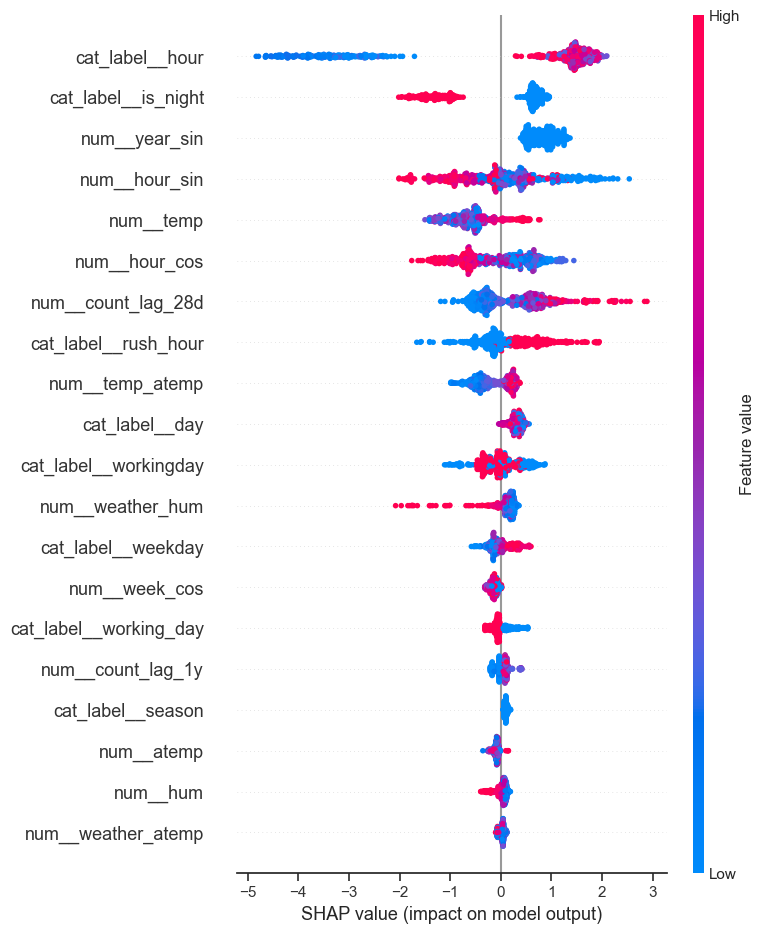

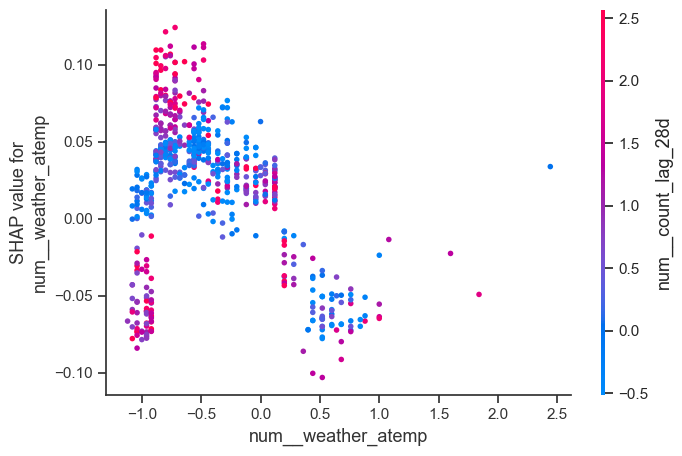

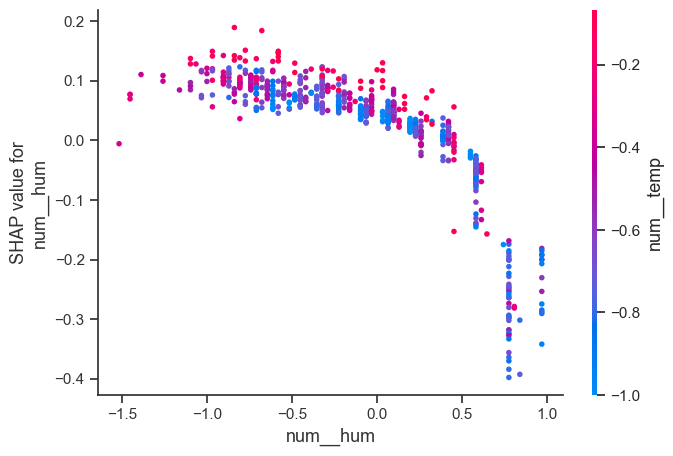

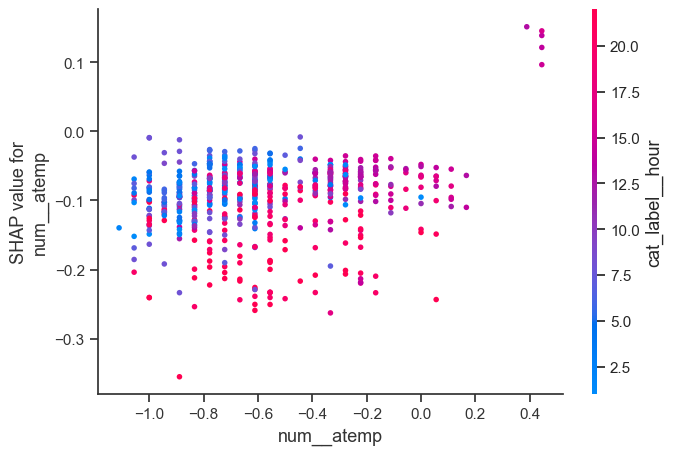

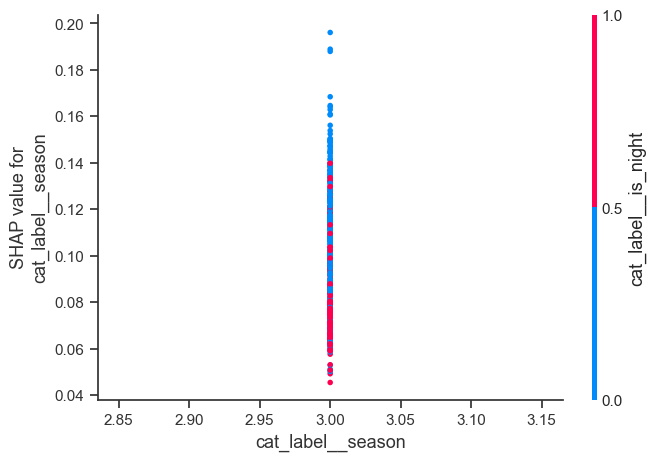

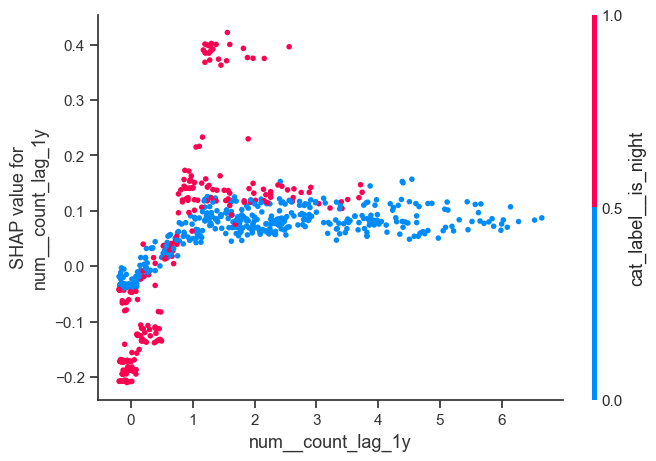

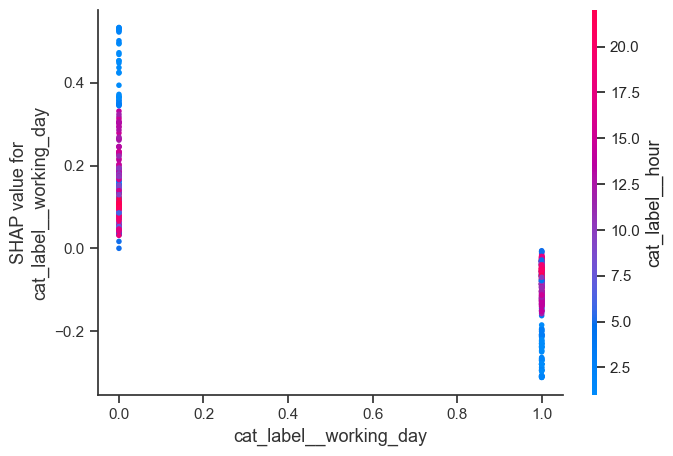

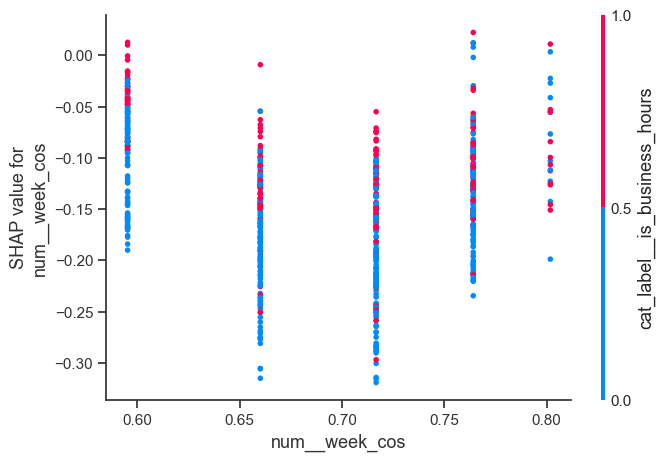

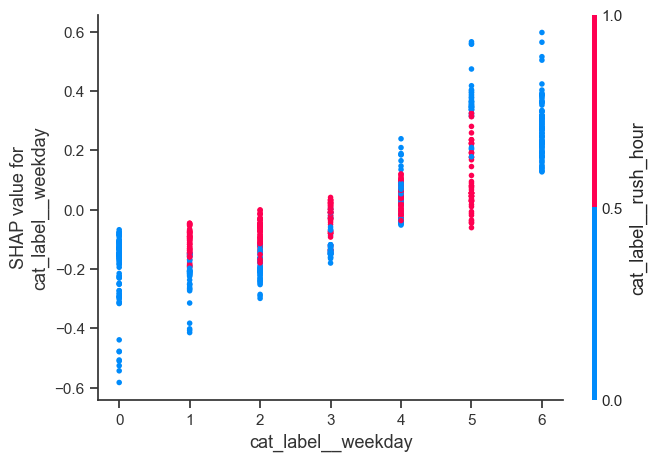

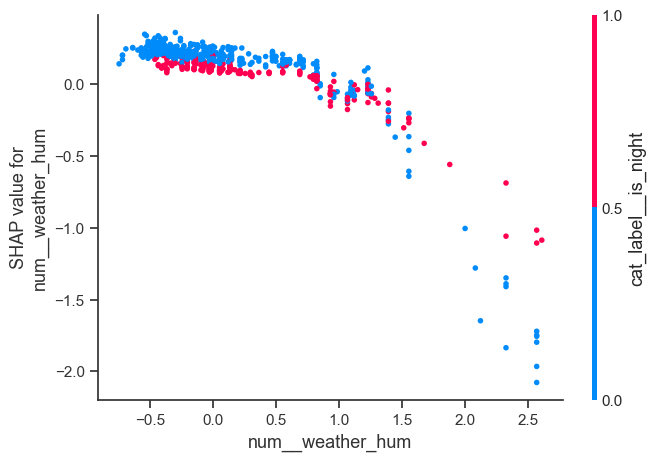

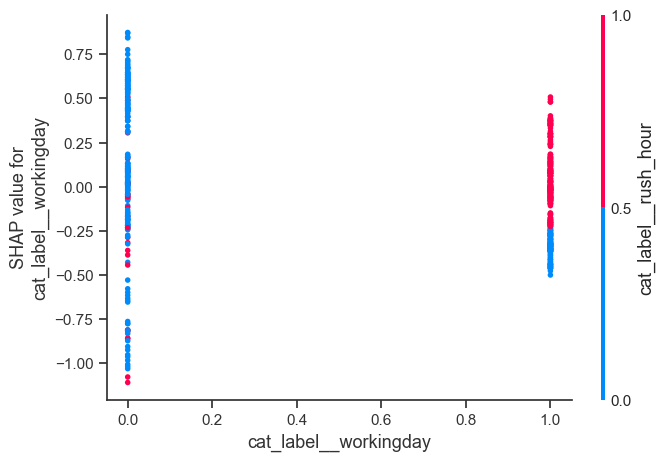

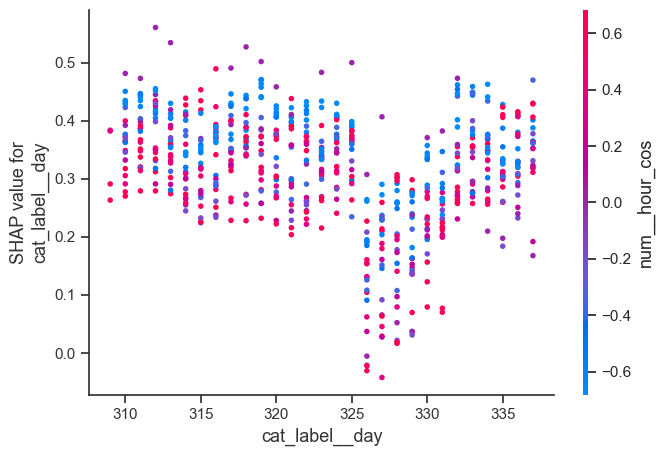

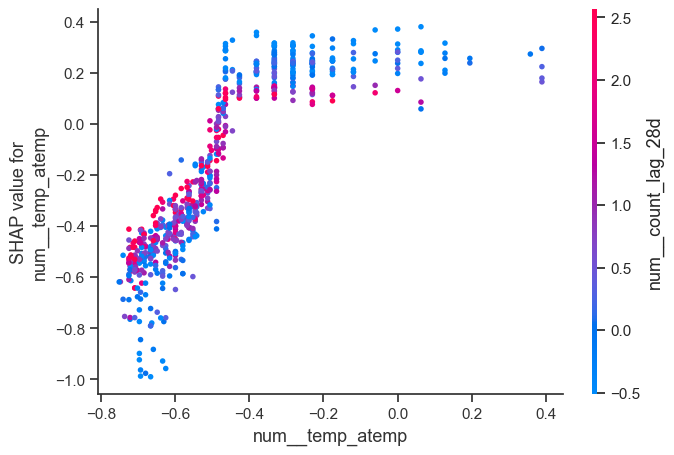

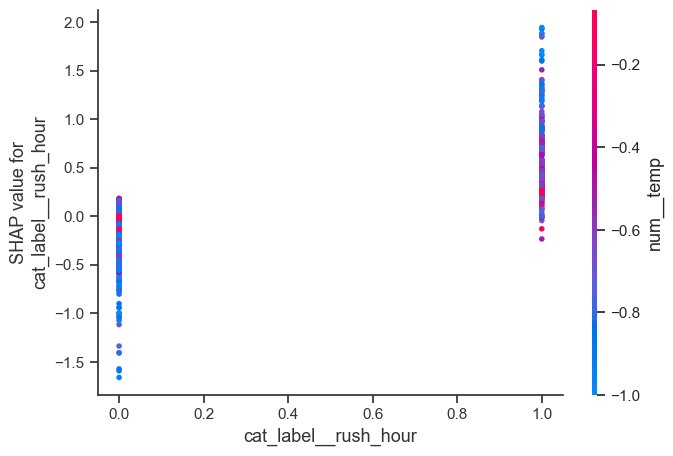

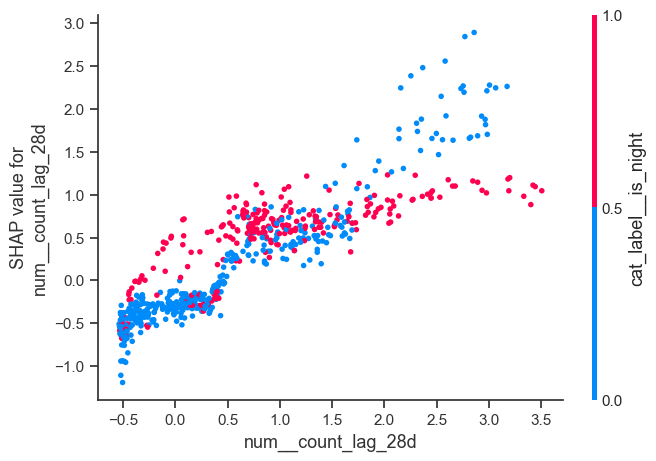

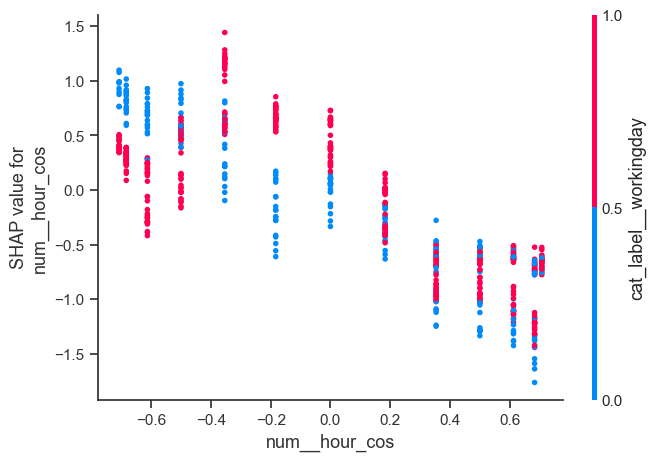

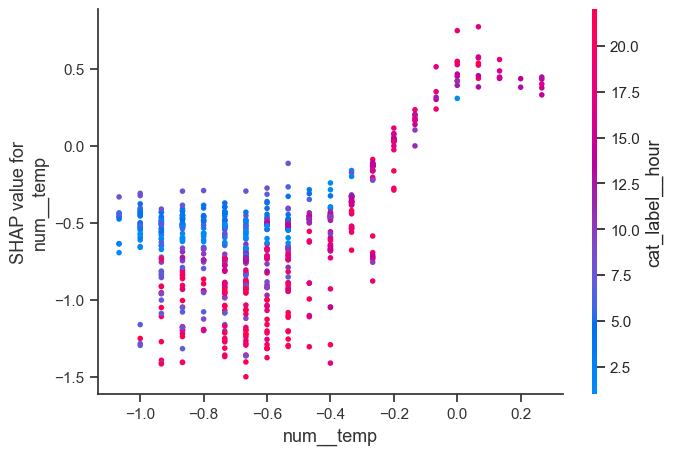

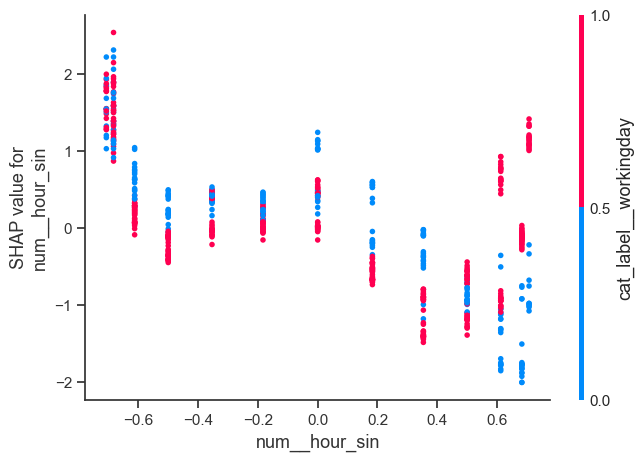

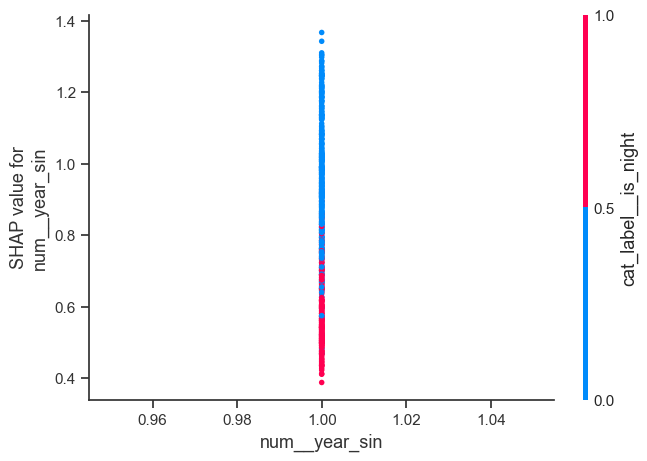

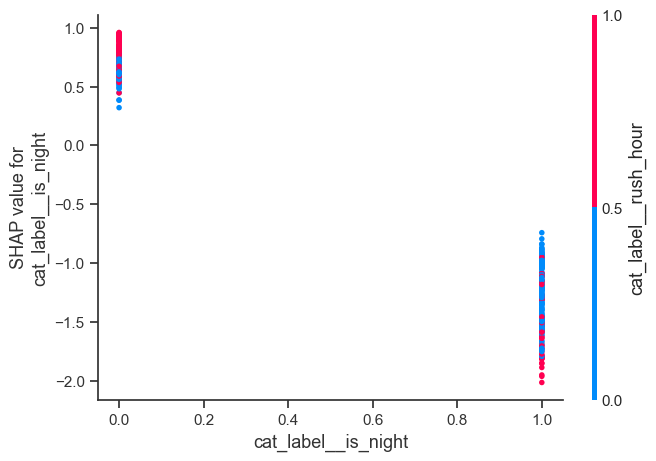

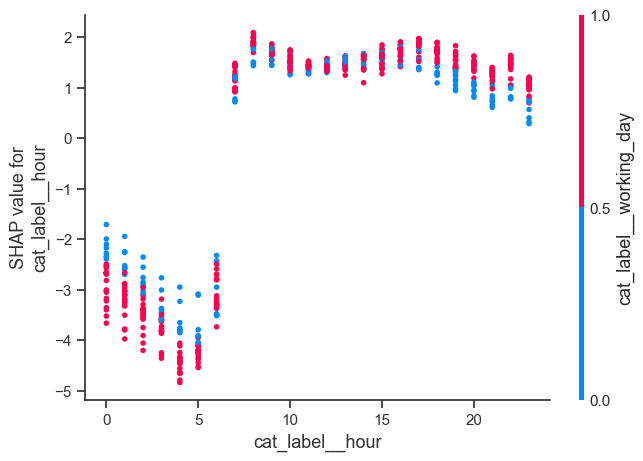

In [102]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_val_processed)

feature_names = preprocessor.get_feature_names_out()

shap.summary_plot(shap_values, X_val_processed, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_values, X_val_processed, feature_names=feature_names)

top_20_features = np.argsort(np.abs(shap_values).mean(axis=0))[-20:]

for feature in top_20_features:
    shap.dependence_plot(feature, shap_values, X_val_processed, feature_names=feature_names)

shap.initjs()

## Recursive Feature Elimination

In [103]:
rmse_list = []
features_list = []
results_dict = {}

current_features = list(range(len(new_column_names)))

while len(current_features) > 1:
    X_train_subset = X_train_processed[:, current_features]
    X_val_subset = X_val_processed[:, current_features]
    
    model.fit(X_train_subset, y_train)
    
    y_pred = inverse_boxcox(model.predict(X_val_subset), lambda_value)
    rmse = mean_squared_error(y_val, y_pred) ** 0.5
    
    rmse_list.append(rmse)
    features_list.append([new_column_names[i] for i in current_features])
    
    results_dict[len(current_features)] = {
        'rmse': rmse,
        'features': [new_column_names[i] for i in current_features]
    }
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val_subset)
    
    shap_importances = np.abs(shap_values).mean(axis=0)
    
    least_important_feature_index = np.argmin(shap_importances)
    
    current_features.pop(least_important_feature_index)

c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but 

In [104]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(len(rmse_list), 0, -1)),
    y=rmse_list,
    mode='lines+markers',
    marker=dict(size=10),
    line=dict(width=2),
    name='RMSE'
))

fig.update_layout(
    title='RMSE vs Number of Features',
    xaxis_title='Number of Features',
    yaxis_title='RMSE',
    template='plotly_white'
)

fig.show()

In [105]:
best_features_dict = results_dict[18]
best_features_dict

{'rmse': 70.75381562934376,
 'features': ['num__temp',
  'num__atemp',
  'num__hum',
  'num__year_sin',
  'num__hour_sin',
  'num__hour_cos',
  'num__week_cos',
  'num__weather_hum',
  'num__temp_atemp',
  'num__count_lag_28d',
  'num__count_lag_1y',
  'cat_label__hour',
  'cat_label__day',
  'cat_label__weekday',
  'cat_label__workingday',
  'cat_label__working_day',
  'cat_label__is_night',
  'cat_label__rush_hour']}

In [106]:
best_features_list = [feature.split('__')[1].rsplit('_0')[0] for feature in best_features_dict['features']]
best_features_list

['temp',
 'atemp',
 'hum',
 'year_sin',
 'hour_sin',
 'hour_cos',
 'week_cos',
 'weather_hum',
 'temp_atemp',
 'count_lag_28d',
 'count_lag_1y',
 'hour',
 'day',
 'weekday',
 'workingday',
 'working_day',
 'is_night',
 'rush_hour']

In [107]:
with open('best_features_list.json', 'w') as f:
    json.dump(best_features_list, f)